<h1>Projet 3 : Développer un moteur de recommandation de films</h1>

## 1. Libraries

In [2]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import missingno as msno
%matplotlib inline
from fancyimpute import KNN
from collections import Counter
from statsmodels import api as sm
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
import scipy.stats as stats
from feature_engine.outlier_removers import Winsorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from feature_engine.categorical_encoders import OneHotCategoricalEncoder

## 2. Data Set

In [4]:
# Importing the Database
movie_data = pd.read_csv("movie_metadata.csv")
movie_data.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [5]:
# Dimensions
movie_data.shape

(5043, 28)

In [6]:
#Reorganization of variables
variables_reorganization = ['movie_title', 'genres', 'country', 'language', 'movie_imdb_link', 'plot_keywords', 'content_rating',
                            'director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name', 'color', 'title_year',
                            'duration', 'facenumber_in_poster', 'aspect_ratio', 'budget', 'gross', 'num_voted_users', 
                            'num_user_for_reviews', 'num_critic_for_reviews', 'imdb_score', 'movie_facebook_likes', 
                            'cast_total_facebook_likes', 'director_facebook_likes', 'actor_1_facebook_likes',
                            'actor_2_facebook_likes', 'actor_3_facebook_likes']                                                                                       
len(variables_reorganization)      

28

In [7]:
movie_data = movie_data[variables_reorganization]
movie_data = movie_data.sort_values(by='title_year', ascending=False)

In [8]:
movie_data.head()

,movie_title,genres,country,language,movie_imdb_link,plot_keywords,content_rating,director_name,actor_1_name,actor_2_name,...,num_voted_users,num_user_for_reviews,num_critic_for_reviews,imdb_score,movie_facebook_likes,cast_total_facebook_likes,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes
2366,Fight Valley,Action|Drama,USA,English,http://www.imdb.com/title/tt4280822/?ref_=fn_t...,NaN,NaN,Rob Hawk,Kari J. Kramer,Erin O'Brien,...,60,6.0,6.0,5.0,1000,2374,97.0,731.0,634.0,319.0
3817,Yoga Hosers,Comedy|Fantasy|Horror|Thriller,USA,English,http://www.imdb.com/title/tt3838992/?ref_=fn_t...,part of trilogy|second part,PG-13,Kevin Smith,Johnny Depp,Haley Joel Osment,...,849,4.0,35.0,4.8,0,46115,0.0,40000.0,3000.0,1000.0
1367,The 5th Wave,Action|Adventure|Sci-Fi|Thriller,USA,English,http://www.imdb.com/title/tt2304933/?ref_=fn_t...,alien|attack|based on novel|based on young adu...,PG-13,J Blakeson,Chloë Grace Moretz,Maggie Siff,...,55617,266.0,194.0,5.2,14000,19974,5.0,17000.0,1000.0,724.0
1742,The Boss,Comedy,USA,English,http://www.imdb.com/title/tt2702724/?ref_=fn_t...,business|girl scouts|orphanage|overweight woma...,R,Ben Falcone,Peter Dinklage,Tyler Labine,...,16984,96.0,154.0,5.3,0,23562,265.0,22000.0,779.0,265.0
519,The Secret Life of Pets,Animation|Comedy|Family,Japan,English,http://www.imdb.com/title/tt2709768/?ref_=fn_t...,animal control|lost animal|mongrel|pet|terrier,PG,Yarrow Cheney,Steve Coogan,Eric Stonestreet,...,24407,155.0,165.0,6.8,36000,4782,11.0,1000.0,904.0,745.0


In [9]:
movie_data = movie_data.reset_index(drop = True)
movie_data.head()

,movie_title,genres,country,language,movie_imdb_link,plot_keywords,content_rating,director_name,actor_1_name,actor_2_name,...,num_voted_users,num_user_for_reviews,num_critic_for_reviews,imdb_score,movie_facebook_likes,cast_total_facebook_likes,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes
0,Fight Valley,Action|Drama,USA,English,http://www.imdb.com/title/tt4280822/?ref_=fn_t...,NaN,NaN,Rob Hawk,Kari J. Kramer,Erin O'Brien,...,60,6.0,6.0,5.0,1000,2374,97.0,731.0,634.0,319.0
1,Yoga Hosers,Comedy|Fantasy|Horror|Thriller,USA,English,http://www.imdb.com/title/tt3838992/?ref_=fn_t...,part of trilogy|second part,PG-13,Kevin Smith,Johnny Depp,Haley Joel Osment,...,849,4.0,35.0,4.8,0,46115,0.0,40000.0,3000.0,1000.0
2,The 5th Wave,Action|Adventure|Sci-Fi|Thriller,USA,English,http://www.imdb.com/title/tt2304933/?ref_=fn_t...,alien|attack|based on novel|based on young adu...,PG-13,J Blakeson,Chloë Grace Moretz,Maggie Siff,...,55617,266.0,194.0,5.2,14000,19974,5.0,17000.0,1000.0,724.0
3,The Boss,Comedy,USA,English,http://www.imdb.com/title/tt2702724/?ref_=fn_t...,business|girl scouts|orphanage|overweight woma...,R,Ben Falcone,Peter Dinklage,Tyler Labine,...,16984,96.0,154.0,5.3,0,23562,265.0,22000.0,779.0,265.0
4,The Secret Life of Pets,Animation|Comedy|Family,Japan,English,http://www.imdb.com/title/tt2709768/?ref_=fn_t...,animal control|lost animal|mongrel|pet|terrier,PG,Yarrow Cheney,Steve Coogan,Eric Stonestreet,...,24407,155.0,165.0,6.8,36000,4782,11.0,1000.0,904.0,745.0


In [10]:
movie_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   movie_title                5043 non-null   object 
 1   genres                     5043 non-null   object 
 2   country                    5038 non-null   object 
 3   language                   5031 non-null   object 
 4   movie_imdb_link            5043 non-null   object 
 5   plot_keywords              4890 non-null   object 
 6   content_rating             4740 non-null   object 
 7   director_name              4939 non-null   object 
 8   actor_1_name               5036 non-null   object 
 9   actor_2_name               5030 non-null   object 
 10  actor_3_name               5020 non-null   object 
 11  color                      5024 non-null   object 
 12  title_year                 4935 non-null   float64
 13  duration                   5028 non-null   float

In [11]:
# Descriptive Statistics
movie_data.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
movie_title,5043,4917,The Fast and the Furious,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
genres,5043,914,Drama,236,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,5038,65,USA,3807,NaN,NaN,NaN,NaN,NaN,NaN,NaN
language,5031,47,English,4704,NaN,NaN,NaN,NaN,NaN,NaN,NaN
movie_imdb_link,5043,4919,http://www.imdb.com/title/tt0077651/?ref_=fn_t...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
plot_keywords,4890,4760,based on novel,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
content_rating,4740,18,R,2118,NaN,NaN,NaN,NaN,NaN,NaN,NaN
director_name,4939,2398,Steven Spielberg,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN
actor_1_name,5036,2097,Robert De Niro,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN
actor_2_name,5030,3032,Morgan Freeman,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Feature Selection / Feature Engineering

### 3.1 Duplicated rows  

In [12]:

#Detection of Duplicates
duplic = movie_data[movie_data.duplicated(subset=['movie_title', 'movie_imdb_link', 'director_name'], keep=False)].sort_values('movie_title')
print(len(duplic))
duplic.head(6)

241


,movie_title,genres,country,language,movie_imdb_link,plot_keywords,content_rating,director_name,actor_1_name,actor_2_name,...,num_voted_users,num_user_for_reviews,num_critic_for_reviews,imdb_score,movie_facebook_likes,cast_total_facebook_likes,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes
4872,"20,000 Leagues Under the Sea",Adventure|Drama|Family|Fantasy|Sci-Fi,USA,English,http://www.imdb.com/title/tt0046672/?ref_=fn_t...,captain|expedition|sea|submarine|whale,Approved,Richard Fleischer,James Mason,Robert J. Wilke,...,22124,108.0,69.0,7.2,0,800,130.0,618.0,53.0,51.0
4873,"20,000 Leagues Under the Sea",Adventure|Drama|Family|Fantasy|Sci-Fi,USA,English,http://www.imdb.com/title/tt0046672/?ref_=fn_t...,captain|expedition|sea|submarine|whale,Approved,Richard Fleischer,James Mason,Robert J. Wilke,...,22123,108.0,69.0,7.2,0,799,130.0,617.0,53.0,51.0
2013,A Dog's Breakfast,Comedy,Canada,English,http://www.imdb.com/title/tt0796314/?ref_=fn_t...,dog|vegetarian,NaN,David Hewlett,Christopher Judge,David Hewlett,...,3262,46.0,8.0,7.0,377,2364,686.0,847.0,686.0,405.0
2015,A Dog's Breakfast,Comedy,Canada,English,http://www.imdb.com/title/tt0796314/?ref_=fn_t...,dog|vegetarian,NaN,David Hewlett,Christopher Judge,David Hewlett,...,3262,46.0,8.0,7.0,377,2364,686.0,847.0,686.0,405.0
4534,A Nightmare on Elm Street,Horror,USA,English,http://www.imdb.com/title/tt0087800/?ref_=fn_t...,freddy krueger|lucid dream|serial killer|slash...,X,Wes Craven,Johnny Depp,Lin Shaye,...,149285,668.0,256.0,7.5,10000,42918,0.0,40000.0,852.0,574.0
4559,A Nightmare on Elm Street,Horror,USA,English,http://www.imdb.com/title/tt0087800/?ref_=fn_t...,freddy krueger|lucid dream|serial killer|slash...,X,Wes Craven,Johnny Depp,Lin Shaye,...,149293,668.0,256.0,7.5,10000,42918,0.0,40000.0,852.0,574.0


In [13]:
# Deletion of Duplicates
movie_data.drop_duplicates(subset=['movie_title', 'movie_imdb_link', 'director_name'], inplace=True)
print(movie_data.shape)
movie_data.head()

(4919, 28)


,movie_title,genres,country,language,movie_imdb_link,plot_keywords,content_rating,director_name,actor_1_name,actor_2_name,...,num_voted_users,num_user_for_reviews,num_critic_for_reviews,imdb_score,movie_facebook_likes,cast_total_facebook_likes,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes
0,Fight Valley,Action|Drama,USA,English,http://www.imdb.com/title/tt4280822/?ref_=fn_t...,NaN,NaN,Rob Hawk,Kari J. Kramer,Erin O'Brien,...,60,6.0,6.0,5.0,1000,2374,97.0,731.0,634.0,319.0
1,Yoga Hosers,Comedy|Fantasy|Horror|Thriller,USA,English,http://www.imdb.com/title/tt3838992/?ref_=fn_t...,part of trilogy|second part,PG-13,Kevin Smith,Johnny Depp,Haley Joel Osment,...,849,4.0,35.0,4.8,0,46115,0.0,40000.0,3000.0,1000.0
2,The 5th Wave,Action|Adventure|Sci-Fi|Thriller,USA,English,http://www.imdb.com/title/tt2304933/?ref_=fn_t...,alien|attack|based on novel|based on young adu...,PG-13,J Blakeson,Chloë Grace Moretz,Maggie Siff,...,55617,266.0,194.0,5.2,14000,19974,5.0,17000.0,1000.0,724.0
3,The Boss,Comedy,USA,English,http://www.imdb.com/title/tt2702724/?ref_=fn_t...,business|girl scouts|orphanage|overweight woma...,R,Ben Falcone,Peter Dinklage,Tyler Labine,...,16984,96.0,154.0,5.3,0,23562,265.0,22000.0,779.0,265.0
4,The Secret Life of Pets,Animation|Comedy|Family,Japan,English,http://www.imdb.com/title/tt2709768/?ref_=fn_t...,animal control|lost animal|mongrel|pet|terrier,PG,Yarrow Cheney,Steve Coogan,Eric Stonestreet,...,24407,155.0,165.0,6.8,36000,4782,11.0,1000.0,904.0,745.0


In [14]:
movie_data.tail()

,movie_title,genres,country,language,movie_imdb_link,plot_keywords,content_rating,director_name,actor_1_name,actor_2_name,...,num_voted_users,num_user_for_reviews,num_critic_for_reviews,imdb_score,movie_facebook_likes,cast_total_facebook_likes,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes
5038,Heroes,Drama|Fantasy|Sci-Fi|Thriller,USA,English,http://www.imdb.com/title/tt0813715/?ref_=fn_t...,father daughter relationship|serial killer|sup...,TV-14,NaN,Sendhil Ramamurthy,Masi Oka,...,202115,379.0,75.0,7.7,0,4908,NaN,1000.0,923.0,833.0
5039,Home Movies,Animation|Comedy|Drama,USA,English,http://www.imdb.com/title/tt0197159/?ref_=fn_t...,coach|friend|school|series|tv series,TV-PG,NaN,Brendon Small,Ron Lynch,...,7458,82.0,11.0,8.2,526,81,NaN,59.0,11.0,6.0
5040,Revolution,Action|Adventure|Drama|Sci-Fi,USA,English,http://www.imdb.com/title/tt2070791/?ref_=fn_t...,2020s|near future|one word series title|post a...,TV-14,NaN,Billy Burke,Tracy Spiridakos,...,72017,323.0,23.0,6.7,17000,5052,NaN,2000.0,821.0,576.0
5041,Happy Valley,Crime|Drama,UK,English,http://www.imdb.com/title/tt3428912/?ref_=fn_t...,caravan|police|police sergeant|tied to a chair...,TV-MA,NaN,Shirley Henderson,James Norton,...,12848,59.0,11.0,8.5,10000,2572,NaN,887.0,340.0,250.0
5042,The Following,Crime|Drama|Mystery|Thriller,USA,English,http://www.imdb.com/title/tt2071645/?ref_=fn_t...,cult|fbi|hideout|prison escape|serial killer,TV-14,NaN,Natalie Zea,Valorie Curry,...,73839,359.0,43.0,7.5,32000,1753,NaN,841.0,593.0,319.0


### 3.2 "color" Processing

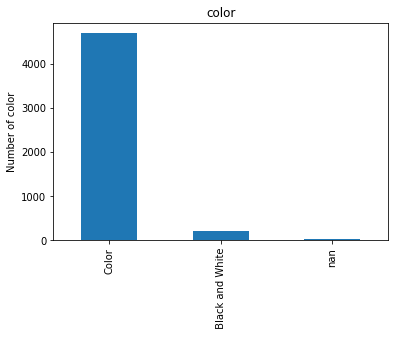

In [15]:
#Color
#To use as target for KNN imputation
plot_color_0 = movie_data["color"].value_counts(dropna=False).plot.bar()
plot_color_0.set_title("color")
plot_color_0.set_ylabel("Number of color")
plt.draw()

In [16]:
# Replace NaNs with Color
# Digitization of the "color" variable (0 et 1, apply(), map(), applymap())
movie_data["color"] = (movie_data["color"].fillna(movie_data["color"].mode()[0])
                      .apply(lambda x: 1 if (x=="Color") else 0))

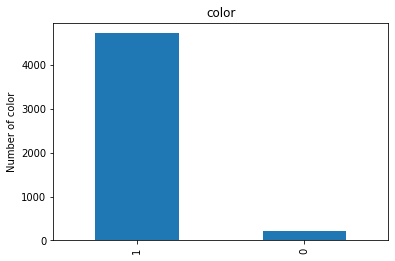

In [17]:
#Color
plot_color_1 = movie_data["color"].value_counts(dropna=False).plot.bar()
plot_color_1.set_title("color")
plot_color_1.set_ylabel("Number of color")
plt.draw()

### 3.3 Numerical variables processing

In [18]:
# Filter the numerical variables
numerics = ["int64", "float64"]
numerical_vars = list(movie_data.select_dtypes(include=numerics).columns)
num_data = movie_data[numerical_vars]
num_data.head()

,color,title_year,duration,facenumber_in_poster,aspect_ratio,budget,gross,num_voted_users,num_user_for_reviews,num_critic_for_reviews,imdb_score,movie_facebook_likes,cast_total_facebook_likes,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes
0,1,2016.0,90.0,4.0,NaN,27000000.0,NaN,60,6.0,6.0,5.0,1000,2374,97.0,731.0,634.0,319.0
1,1,2016.0,88.0,7.0,NaN,5000000.0,NaN,849,4.0,35.0,4.8,0,46115,0.0,40000.0,3000.0,1000.0
2,1,2016.0,112.0,0.0,2.35,38000000.0,34912982.0,55617,266.0,194.0,5.2,14000,19974,5.0,17000.0,1000.0,724.0
3,1,2016.0,99.0,1.0,1.85,29000000.0,63034755.0,16984,96.0,154.0,5.3,0,23562,265.0,22000.0,779.0,265.0
4,1,2016.0,87.0,0.0,1.85,75000000.0,323505540.0,24407,155.0,165.0,6.8,36000,4782,11.0,1000.0,904.0,745.0


In [19]:
num_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4919 entries, 0 to 5042
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      4919 non-null   int64  
 1   title_year                 4813 non-null   float64
 2   duration                   4904 non-null   float64
 3   facenumber_in_poster       4906 non-null   float64
 4   aspect_ratio               4593 non-null   float64
 5   budget                     4434 non-null   float64
 6   gross                      4056 non-null   float64
 7   num_voted_users            4919 non-null   int64  
 8   num_user_for_reviews       4898 non-null   float64
 9   num_critic_for_reviews     4870 non-null   float64
 10  imdb_score                 4919 non-null   float64
 11  movie_facebook_likes       4919 non-null   int64  
 12  cast_total_facebook_likes  4919 non-null   int64  
 13  director_facebook_likes    4817 non-null   float

### 3.3.1 Visualisation

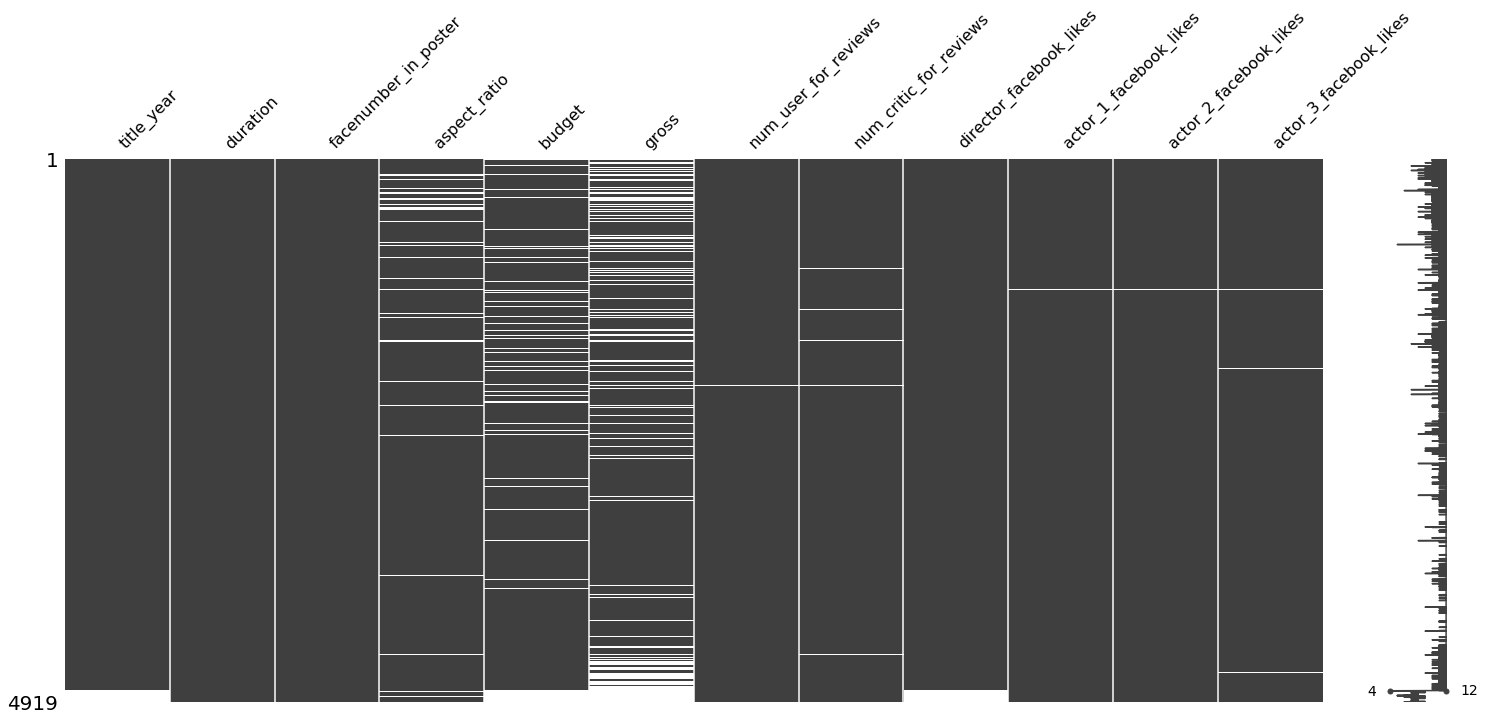

In [20]:
# NaN cartography
missingdata = num_data.columns[num_data.isnull().any()].tolist()
msno.matrix(num_data[missingdata])
plt.draw()

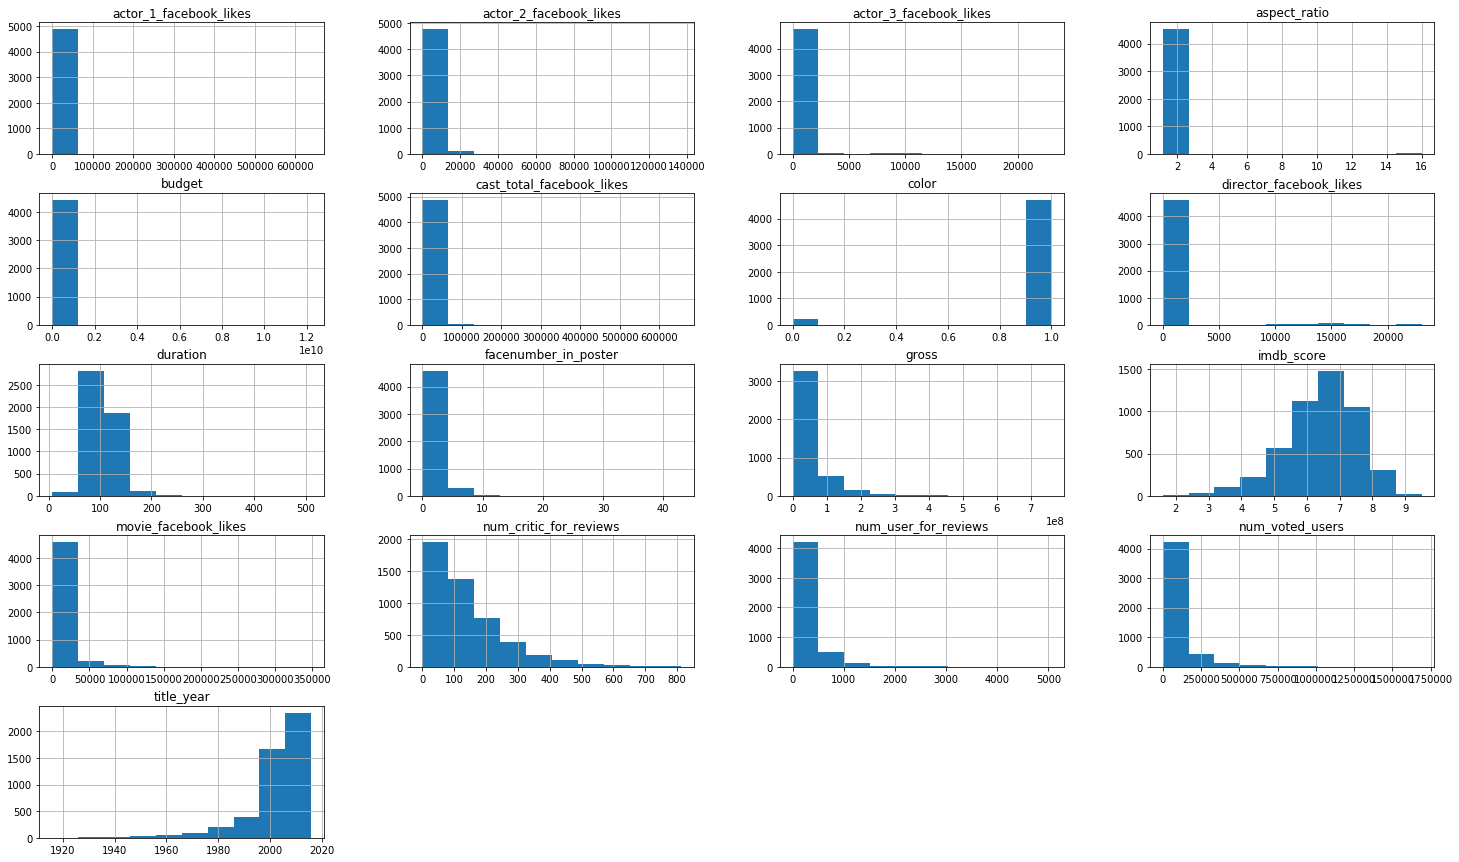

In [21]:
# Numerical variables distribution
plt.rcParams["figure.figsize"]=[25,15]
num_data.hist()
plt.draw()

C:\Users\adild\Anaconda3\envs\deeplearningaz\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


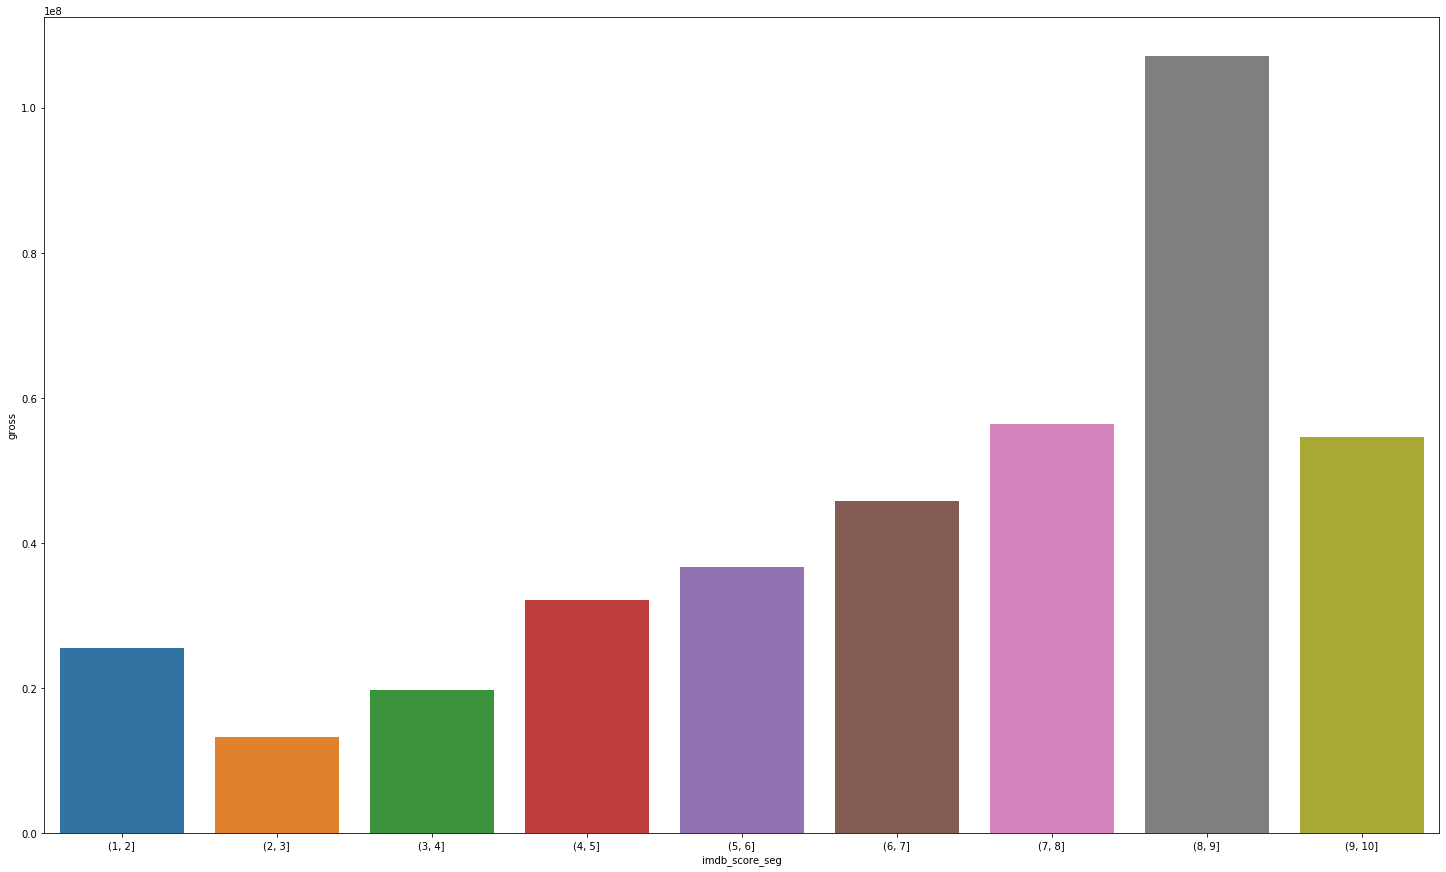

In [22]:
#Gross per imdb score segment
num_data['imdb_score_seg'] = pd.cut(num_data.imdb_score, bins=list(np.arange(1, 11))) 
sns.barplot(num_data['imdb_score_seg'], num_data['gross'], ci=None )
plt.draw()

C:\Users\adild\Anaconda3\envs\deeplearningaz\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


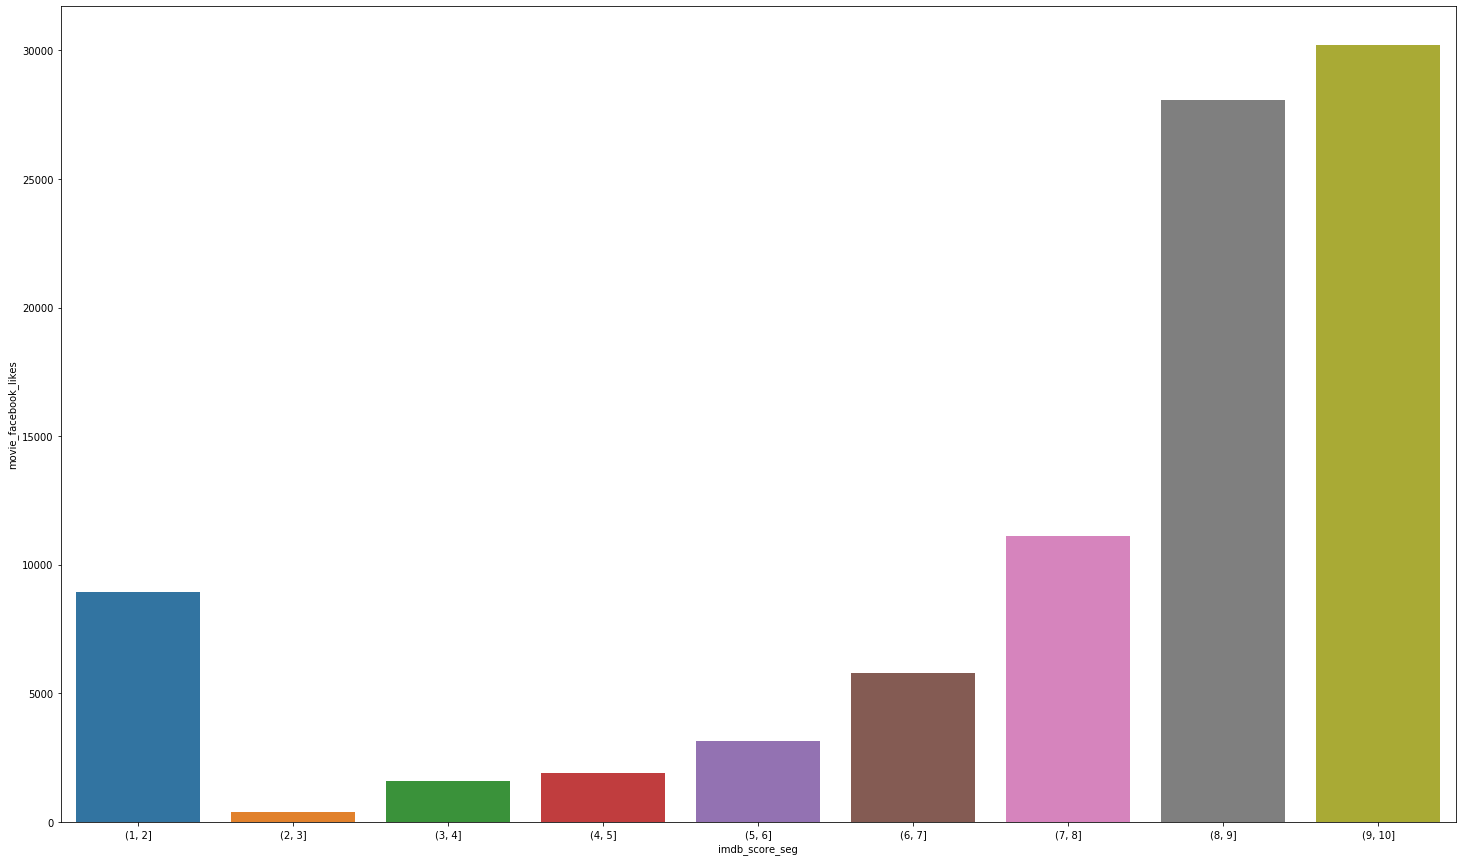

In [23]:
#Segment values into discrete intervals
num_data['imdb_score_seg'] = pd.cut(num_data.imdb_score, bins=list(np.arange(1, 11)))
sns.barplot(num_data['imdb_score_seg'], num_data['movie_facebook_likes'], ci=None)
plt.draw()

C:\Users\adild\Anaconda3\envs\deeplearningaz\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


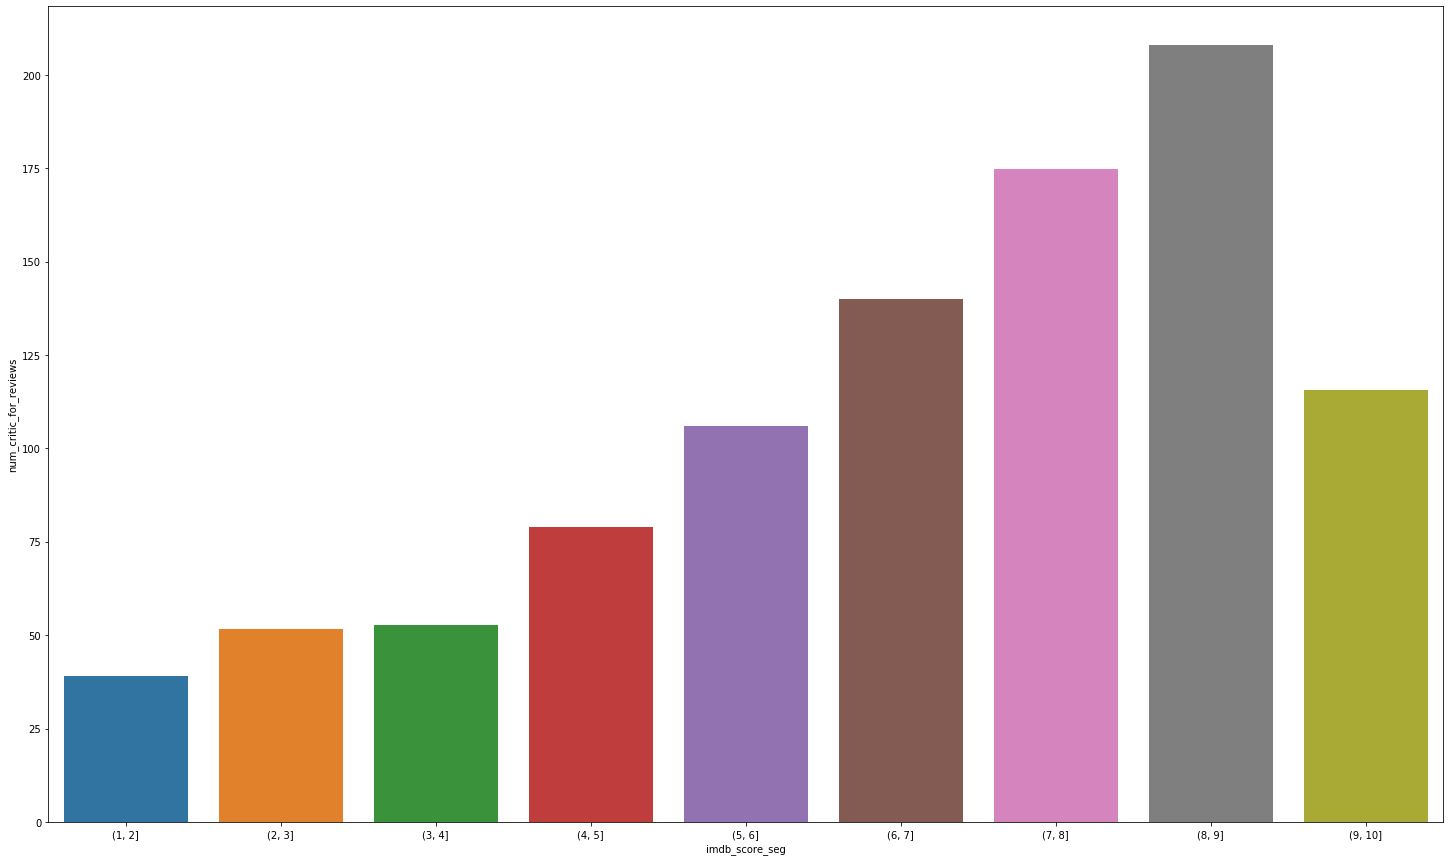

In [24]:
num_data['imdb_score_seg'] = pd.cut(num_data.imdb_score, bins=list(np.arange(1, 11)))
sns.barplot(num_data['imdb_score_seg'], num_data['num_critic_for_reviews'], ci=None)
plt.draw()

In [25]:
del num_data['imdb_score_seg']

### 3.3.2 Outliers

In [26]:
# Outliers Diagnostic
# Function to create histogram and boxplot 
def diag_outliers(df, variable):
    
    # define figure size
    plt.figure(figsize=(13, 3))
    
    # histogram
    plt.subplot(1, 2, 1) # 1 row, 2 columns, position histogram
    sns.distplot(df[variable], bins=30)
    plt.title('histogram')
    
    # boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('boxplot')
    
    plt.show()

#### Movie General Variables

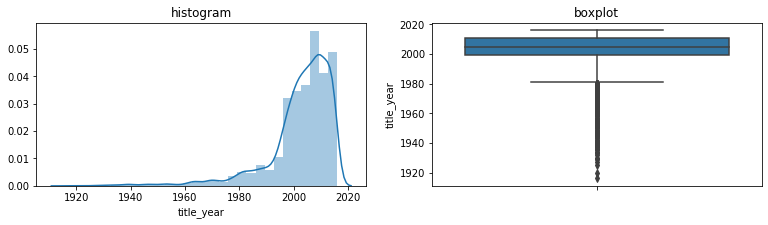

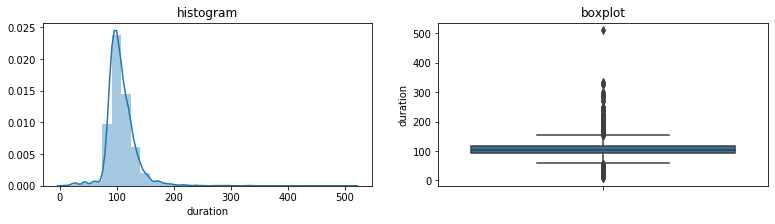

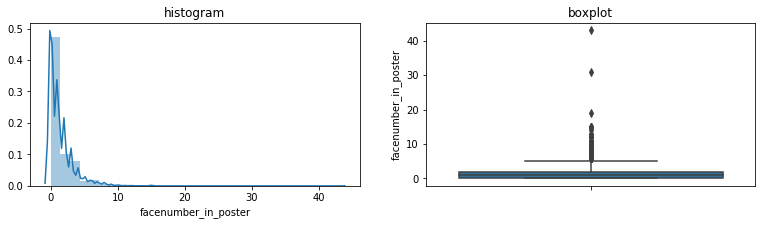

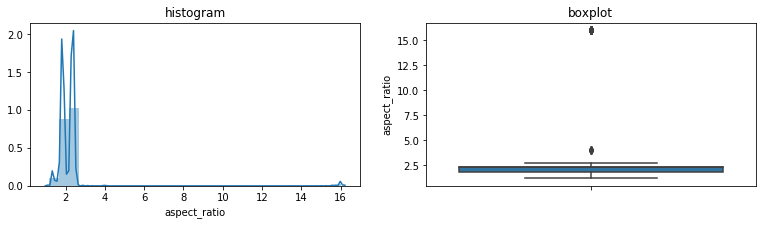

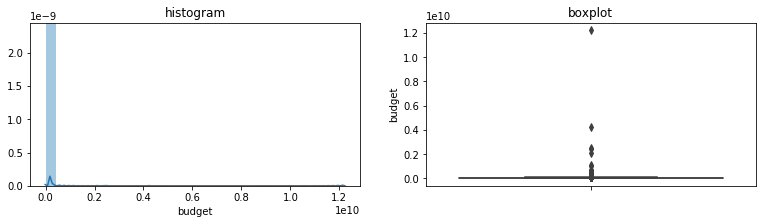

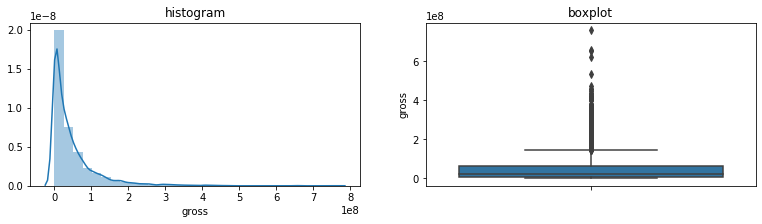

In [27]:
# Visualize outliers in movie general variables
diag_outliers(num_data, 'title_year')
diag_outliers(num_data, 'duration')
diag_outliers(num_data, 'facenumber_in_poster')
diag_outliers(num_data, 'aspect_ratio')
diag_outliers(num_data, 'budget')
diag_outliers(num_data, 'gross')

In [28]:
# Calculate the boundaries outside
def boundaries (df, variable, distance):
    
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)
    
    return upper_boundary, lower_boundary

In [29]:
#Limits for duration
title_year_upper_limit, title_year_lower_limit = boundaries (num_data, 'title_year', 1.5)
duration_upper_limit, duration_lower_limit = boundaries (num_data, 'duration', 1.5)
facenumber_in_poster_upper_limit, facenumber_in_poster_lower_limit = boundaries (num_data, 'facenumber_in_poster', 1.5)
budget_upper_limit, budget_lower_limit = boundaries (num_data, 'budget', 1.5)
gross_upper_limit, gross_lower_limit = boundaries (num_data, 'gross', 1.5)
aspect_ratio_upper_limit, aspect_ratio_lower_limit = boundaries (num_data, 'aspect_ratio', 1.5)

print('title_year',(title_year_upper_limit, title_year_lower_limit))
print('duration',(duration_upper_limit, duration_lower_limit))
print('facenumber_in_poster',(facenumber_in_poster_upper_limit, facenumber_in_poster_lower_limit))
print('budget',(budget_upper_limit, budget_lower_limit))
print('gross',(gross_upper_limit, gross_lower_limit ))
print('aspect_ratio',(aspect_ratio_upper_limit, aspect_ratio_lower_limit))

title_year (2029.0, 1981.0)
duration (155.5, 55.5)
facenumber_in_poster (5.0, -3.0)
budget (98500000.0, -49500000.0)
gross (145235422.875, -79127288.125)
aspect_ratio (3.1, 1.1)


In [30]:
#Checking of some films made before 1980
#movie_data.query('title_year == 1980').sample(2)
#movie_data.query('title_year == 1937').sample(2)
#movie_data.query('title_year == 1920').head()
#movie_data.query('title_year == 1965').sample(2)
movie_data.query(' title_year == 1916').head()

,movie_title,genres,country,language,movie_imdb_link,plot_keywords,content_rating,director_name,actor_1_name,actor_2_name,...,num_voted_users,num_user_for_reviews,num_critic_for_reviews,imdb_score,movie_facebook_likes,cast_total_facebook_likes,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes
4934,Intolerance: Love's Struggle Throughout the Ages,Drama|History|War,USA,NaN,http://www.imdb.com/title/tt0006864/?ref_=fn_t...,huguenot|intolerance|medicis|protestant|wedding,Not Rated,D.W. Griffith,Lillian Gish,Mae Marsh,...,10718,88.0,69.0,8.0,691,481,204.0,436.0,22.0,9.0


In [31]:
movie_data.query('duration <= 56')
# Checking: duration(Jesus People, Taxi to the Dark Side, The Touch)> 90 min

,movie_title,genres,country,language,movie_imdb_link,plot_keywords,content_rating,director_name,actor_1_name,actor_2_name,...,num_voted_users,num_user_for_reviews,num_critic_for_reviews,imdb_score,movie_facebook_likes,cast_total_facebook_likes,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes
472,Rise of the Entrepreneur: The Search for a Bet...,Documentary,USA,English,http://www.imdb.com/title/tt4273494/?ref_=fn_t...,business|entrepreneur|network marketing,G,Joe Kenemore,Bob Proctor,Jack Canfield,...,78,10.0,NaN,8.2,460,10,0.0,8.0,2.0,0.0
490,Alpha and Omega 4: The Legend of the Saw Tooth...,Action|Adventure|Animation|Comedy|Drama|Family...,USA,NaN,http://www.imdb.com/title/tt4061848/?ref_=fn_t...,blindness|cave|spirit|wolf|wolf cub,NaN,Richard Rich,Debi Derryberry,Kate Higgins,...,192,6.0,2.0,6.0,41,236,24.0,122.0,35.0,29.0
840,Vessel,Horror|Sci-Fi|Short|Thriller,USA,English,http://www.imdb.com/title/tt2164708/?ref_=fn_t...,alien|flight attendant|monster|pilot|tentacle,NaN,Clark Baker,Taylor Pigeon,Alan Pietruszewski,...,292,3.0,1.0,6.2,14,315,0.0,134.0,93.0,37.0
1441,Sea Rex 3D: Journey to a Prehistoric World,Documentary,UK,English,http://www.imdb.com/title/tt1529567/?ref_=fn_t...,3d|imax|plesiosaur|sea|water,NaN,Ronan Chapalain,Norbert Ferrer,Guillaume Denaiffe,...,296,4.0,7.0,6.9,89,55,0.0,55.0,0.0,0.0
1898,Flame and Citron,Drama|History|Thriller|War,Denmark,Danish,http://www.imdb.com/title/tt0920458/?ref_=fn_t...,danish|double agent|nazi|nazi occupation|resis...,Not Rated,Ole Christian Madsen,Lars Mikkelsen,Thure Lindhardt,...,14247,44.0,80.0,7.3,0,1098,28.0,573.0,197.0,104.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5035,The Girlfriend Experience,Drama,USA,English,http://www.imdb.com/title/tt3846642/?ref_=fn_t...,escort|female nudity|friendship|money|sex scene,TV-MA,NaN,Mary Lynn Rajskub,Riley Keough,...,3282,17.0,19.0,7.3,632,1961,NaN,934.0,691.0,201.0
5037,Jesse,Comedy,USA,English,http://www.imdb.com/title/tt0156196/?ref_=fn_t...,1990s|brother sister relationship|female prota...,NaN,NaN,Eric Lloyd,David DeLuise,...,954,14.0,NaN,5.9,57,1713,NaN,775.0,275.0,223.0
5039,Home Movies,Animation|Comedy|Drama,USA,English,http://www.imdb.com/title/tt0197159/?ref_=fn_t...,coach|friend|school|series|tv series,TV-PG,NaN,Brendon Small,Ron Lynch,...,7458,82.0,11.0,8.2,526,81,NaN,59.0,11.0,6.0
5040,Revolution,Action|Adventure|Drama|Sci-Fi,USA,English,http://www.imdb.com/title/tt2070791/?ref_=fn_t...,2020s|near future|one word series title|post a...,TV-14,NaN,Billy Burke,Tracy Spiridakos,...,72017,323.0,23.0,6.7,17000,5052,NaN,2000.0,821.0,576.0


In [32]:
# Checking:
movie_data.query('facenumber_in_poster == 15').sample(5)

,movie_title,genres,country,language,movie_imdb_link,plot_keywords,content_rating,director_name,actor_1_name,actor_2_name,...,num_voted_users,num_user_for_reviews,num_critic_for_reviews,imdb_score,movie_facebook_likes,cast_total_facebook_likes,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes
514,The Expendables 3,Action|Adventure|Thriller,USA,English,http://www.imdb.com/title/tt2333784/?ref_=fn_t...,battle|fight|mission|pg 13 sequel to r rated f...,PG-13,Patrick Hughes,Jason Statham,Sylvester Stallone,...,127258,351.0,320.0,6.1,56000,52610,385.0,26000.0,13000.0,11000.0
1098,New Year's Eve,Comedy|Romance,USA,English,http://www.imdb.com/title/tt1598822/?ref_=fn_t...,expecting|kiss|new year|new year's eve|singer,PG-13,Garry Marshall,Robert De Niro,Common,...,66579,134.0,200.0,5.7,20000,23456,0.0,22000.0,988.0,307.0
2802,As It Is in Heaven,Comedy|Drama|Music|Romance,Sweden,Swedish,http://www.imdb.com/title/tt0382330/?ref_=fn_t...,amazing grace the hymn|choir|heart attack|home...,NaN,Kay Pollak,Michael Nyqvist,Frida Hallgren,...,13543,94.0,34.0,7.6,0,774,10.0,690.0,24.0,19.0
3920,Boogie Nights,Drama,USA,English,http://www.imdb.com/title/tt0118749/?ref_=fn_t...,1970s|adult entertainment industry|nightclub|p...,R,Paul Thomas Anderson,Don Cheadle,Nicole Ari Parker,...,189032,560.0,153.0,7.9,0,3677,0.0,3000.0,360.0,170.0
2903,Cheaper by the Dozen,Comedy|Family,USA,English,http://www.imdb.com/title/tt0349205/?ref_=fn_t...,9 year old|house|illinois|new job|vomiting,PG,Shawn Levy,Tom Welling,Alyson Stoner,...,75152,288.0,104.0,5.8,0,7014,189.0,3000.0,2000.0,597.0


In [33]:
# Now Let's replace the outliers by NaNs

# duration
num_data['duration'] = np.where(num_data['duration'] > 240, np.NaN,
                               np.where(num_data['duration'] < 80, np.NaN, num_data['duration'])) 
# facenumber_in_poster 
num_data['facenumber_in_poster'] = np.where(num_data['facenumber_in_poster'] > 7, np.NaN, num_data['facenumber_in_poster'])

# aspect_ratio 
num_data['aspect_ratio'] = np.where(num_data['aspect_ratio'] > 3.5, np.NaN,
                               np.where(num_data['aspect_ratio'] < 1, np.NaN, num_data['aspect_ratio'])) 

# budget 
num_data['budget'] = np.where(num_data['budget'] > 98500000.0, np.NaN, num_data['budget'])
                                  
# gross
num_data['gross'] = np.where(num_data['gross'] > 145235423.0, np.NaN, num_data['gross'])
                                

C:\Users\adild\Anaconda3\envs\deeplearningaz\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\adild\Anaconda3\envs\deeplearningaz\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\adild\Anaconda3\envs\deeplearningaz\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [34]:
num_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4919 entries, 0 to 5042
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      4919 non-null   int64  
 1   title_year                 4813 non-null   float64
 2   duration                   4694 non-null   float64
 3   facenumber_in_poster       4821 non-null   float64
 4   aspect_ratio               4541 non-null   float64
 5   budget                     4090 non-null   float64
 6   gross                      3764 non-null   float64
 7   num_voted_users            4919 non-null   int64  
 8   num_user_for_reviews       4898 non-null   float64
 9   num_critic_for_reviews     4870 non-null   float64
 10  imdb_score                 4919 non-null   float64
 11  movie_facebook_likes       4919 non-null   int64  
 12  cast_total_facebook_likes  4919 non-null   int64  
 13  director_facebook_likes    4817 non-null   float

#### Movies Users Variables

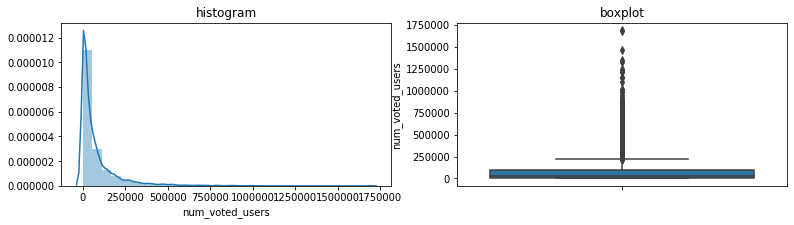

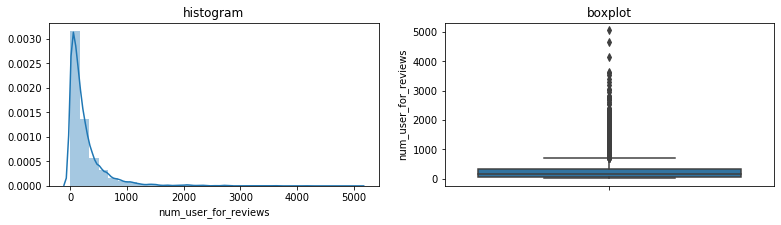

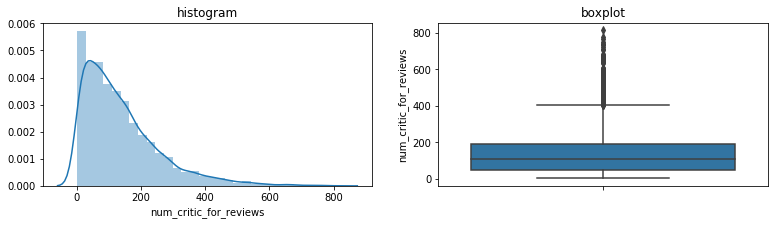

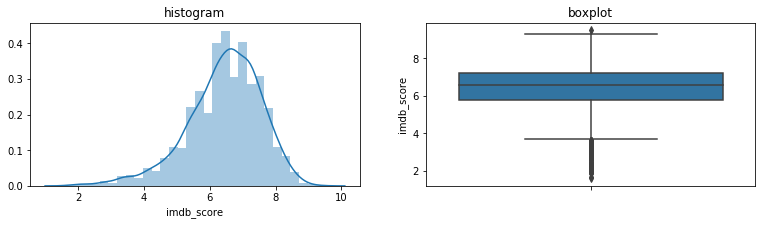

In [35]:
# Visualize outliers in Movies Users Variables
diag_outliers(num_data, 'num_voted_users')
diag_outliers(num_data, 'num_user_for_reviews')
diag_outliers(num_data, 'num_critic_for_reviews')
diag_outliers(num_data, 'imdb_score')

In [36]:
num_voted_users_upper_limit, num_voted_users_lower_limit = boundaries (num_data, 'num_voted_users', 1.5)
num_user_for_reviews_upper_limit, num_user_for_reviews_lower_limit = boundaries (num_data, 'num_user_for_reviews', 1.5)
num_critic_for_reviews_upper_limit, num_critic_for_reviews_lower_limit = boundaries (num_data, 'num_critic_for_reviews', 1.5)
imdb_score_upper_limit, imdb_score_lower_limit = boundaries (num_data, 'imdb_score', 1.5)

print('num_voted_users',(num_voted_users_upper_limit, num_voted_users_lower_limit))
print('num_user_for_reviews',(num_user_for_reviews_upper_limit, num_user_for_reviews_lower_limit))
print('num_critic_for_reviews',(num_critic_for_reviews_upper_limit, num_critic_for_reviews_lower_limit))
print('imdb_score',(imdb_score_upper_limit, imdb_score_lower_limit))


num_voted_users (221859.0, -119745.0)
num_user_for_reviews (704.0, -320.0)
num_critic_for_reviews (404.0, -164.0)
imdb_score (9.3, 3.6999999999999993)


In [37]:
# Now Let's replace the outliers by NaNs

# num_voted_users
num_data['num_voted_users'] = np.where(num_data['num_voted_users'] > 222000.0, np.NaN, num_data['num_voted_users'])
                               
# num_user_for_reviews 
num_data['num_user_for_reviews'] = np.where(num_data['num_user_for_reviews'] > 704.0 , np.NaN, num_data['num_user_for_reviews'])

# num_critic_for_reviews
num_data['num_critic_for_reviews'] = np.where(num_data['num_critic_for_reviews'] > 404, np.NaN, num_data['num_critic_for_reviews'])
                                

# imdb_score 
num_data['imdb_score'] = np.where(num_data['imdb_score'] > 9.3, np.NaN,
                               np.where(num_data['imdb_score'] < 3.7, np.NaN, num_data['imdb_score'])) 

C:\Users\adild\Anaconda3\envs\deeplearningaz\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\adild\Anaconda3\envs\deeplearningaz\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\adild\Anaconda3\envs\deeplearningaz\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [38]:
num_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4919 entries, 0 to 5042
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      4919 non-null   int64  
 1   title_year                 4813 non-null   float64
 2   duration                   4694 non-null   float64
 3   facenumber_in_poster       4821 non-null   float64
 4   aspect_ratio               4541 non-null   float64
 5   budget                     4090 non-null   float64
 6   gross                      3764 non-null   float64
 7   num_voted_users            4456 non-null   float64
 8   num_user_for_reviews       4518 non-null   float64
 9   num_critic_for_reviews     4669 non-null   float64
 10  imdb_score                 4801 non-null   float64
 11  movie_facebook_likes       4919 non-null   int64  
 12  cast_total_facebook_likes  4919 non-null   int64  
 13  director_facebook_likes    4817 non-null   float

#### Movies Facebook Variables

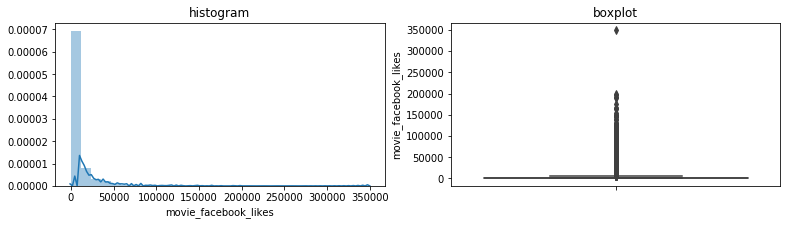

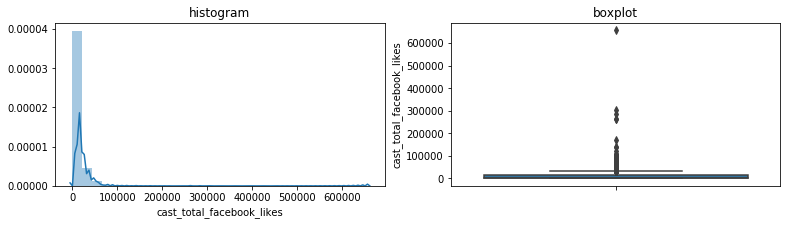

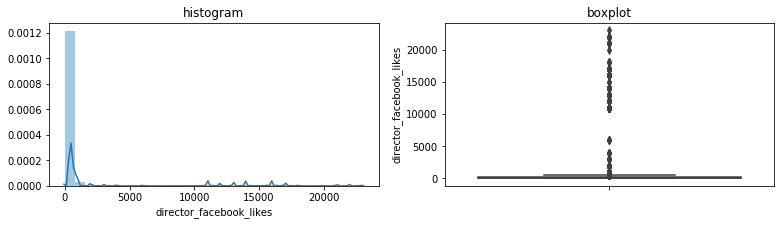

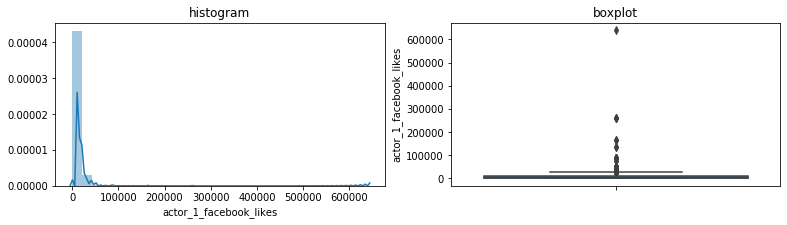

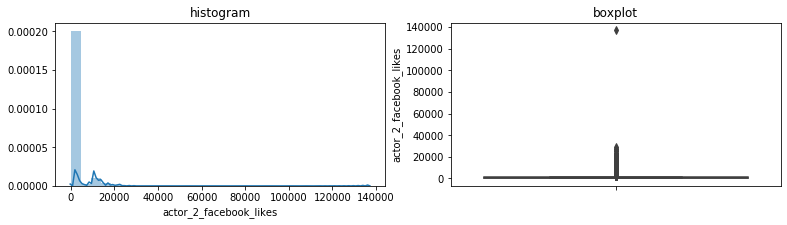

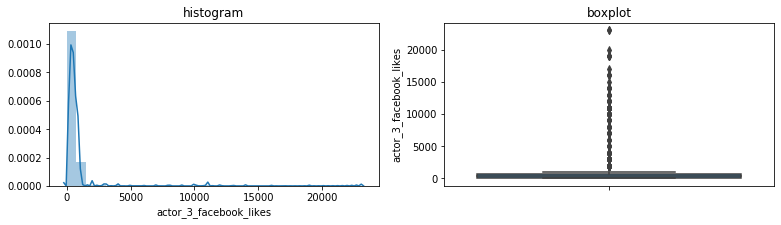

In [39]:
diag_outliers(num_data, 'movie_facebook_likes')
diag_outliers(num_data, 'cast_total_facebook_likes')
diag_outliers(num_data, 'director_facebook_likes')
diag_outliers(num_data, 'actor_1_facebook_likes')
diag_outliers(num_data, 'actor_2_facebook_likes')
diag_outliers(num_data, 'actor_3_facebook_likes')

In [40]:
movie_facebook_likes_upper_limit, movie_facebook_likes_lower_limit = boundaries (num_data, 'movie_facebook_likes', 1.5)
cast_total_facebook_likes_upper_limit, cast_total_facebook_likes_lower_limit = boundaries (num_data, 'cast_total_facebook_likes', 1.5)
director_facebook_likes_upper_limit, director_facebook_likes_lower_limit = boundaries (num_data, 'director_facebook_likes', 1.5)
actor_1_facebook_likes_upper_limit, actor_1_facebook_likes_lower_limit = boundaries (num_data, 'actor_1_facebook_likes', 1.5)
actor_2_facebook_likes_upper_limit, actor_2_facebook_likes_lower_limit = boundaries (num_data, 'actor_2_facebook_likes', 1.5)
actor_3_facebook_likes_upper_limit, actor_3_facebook_likes_lower_limit = boundaries (num_data, 'actor_3_facebook_likes', 1.5)

print('movie_facebook_likes',(movie_facebook_likes_upper_limit, movie_facebook_likes_lower_limit))
print('cast_total_facebook_likes',(cast_total_facebook_likes_upper_limit, cast_total_facebook_likes_lower_limit))
print('director_facebook_likes',(director_facebook_likes_upper_limit, director_facebook_likes_lower_limit))
print('actor_1_facebook_likes',(actor_1_facebook_likes_upper_limit, actor_1_facebook_likes_lower_limit))
print('actor_2_facebook_likes',(actor_2_facebook_likes_upper_limit, actor_2_facebook_likes_lower_limit))
print('actor_3_facebook_likes',(actor_3_facebook_likes_upper_limit, actor_3_facebook_likes_lower_limit))

movie_facebook_likes (5000.0, -3000.0)
cast_total_facebook_likes (31937.75, -16932.25)
director_facebook_likes (464.5, -267.5)
actor_1_facebook_likes (26589.5, -14982.5)
actor_2_facebook_likes (1864.5, -675.5)
actor_3_facebook_likes (1384.5, -619.5)


In [41]:
# movie_facebook_likes
num_data['movie_facebook_likes'] = np.where(num_data['movie_facebook_likes'] > 5000.0, np.NaN, num_data['movie_facebook_likes'])
                               
# cast_total_facebook_likes 
num_data['cast_total_facebook_likes'] = np.where(num_data['cast_total_facebook_likes'] > 31938.0, np.NaN, num_data['cast_total_facebook_likes'])

# director_facebook_likes
num_data['director_facebook_likes'] = np.where(num_data['director_facebook_likes'] > 465.0, np.NaN, num_data['director_facebook_likes'])

# actor_1_facebook_likes
num_data['actor_1_facebook_likes'] = np.where(num_data['actor_1_facebook_likes'] > 26590.0, np.NaN, num_data['actor_1_facebook_likes'])
                               
# actor_2_facebook_likes
num_data['actor_2_facebook_likes'] = np.where(num_data['actor_2_facebook_likes'] > 1865.0 , np.NaN, num_data['actor_2_facebook_likes'])

# actor_3_facebook_likes
num_data['actor_3_facebook_likes'] = np.where(num_data['actor_3_facebook_likes'] > 1385.0, np.NaN, num_data['actor_3_facebook_likes'])

C:\Users\adild\Anaconda3\envs\deeplearningaz\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\adild\Anaconda3\envs\deeplearningaz\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\adild\Anaconda3\envs\deeplearningaz\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [42]:
num_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4919 entries, 0 to 5042
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      4919 non-null   int64  
 1   title_year                 4813 non-null   float64
 2   duration                   4694 non-null   float64
 3   facenumber_in_poster       4821 non-null   float64
 4   aspect_ratio               4541 non-null   float64
 5   budget                     4090 non-null   float64
 6   gross                      3764 non-null   float64
 7   num_voted_users            4456 non-null   float64
 8   num_user_for_reviews       4518 non-null   float64
 9   num_critic_for_reviews     4669 non-null   float64
 10  imdb_score                 4801 non-null   float64
 11  movie_facebook_likes       3779 non-null   float64
 12  cast_total_facebook_likes  4581 non-null   float64
 13  director_facebook_likes    4212 non-null   float

### 3.3.3 NaNs processing

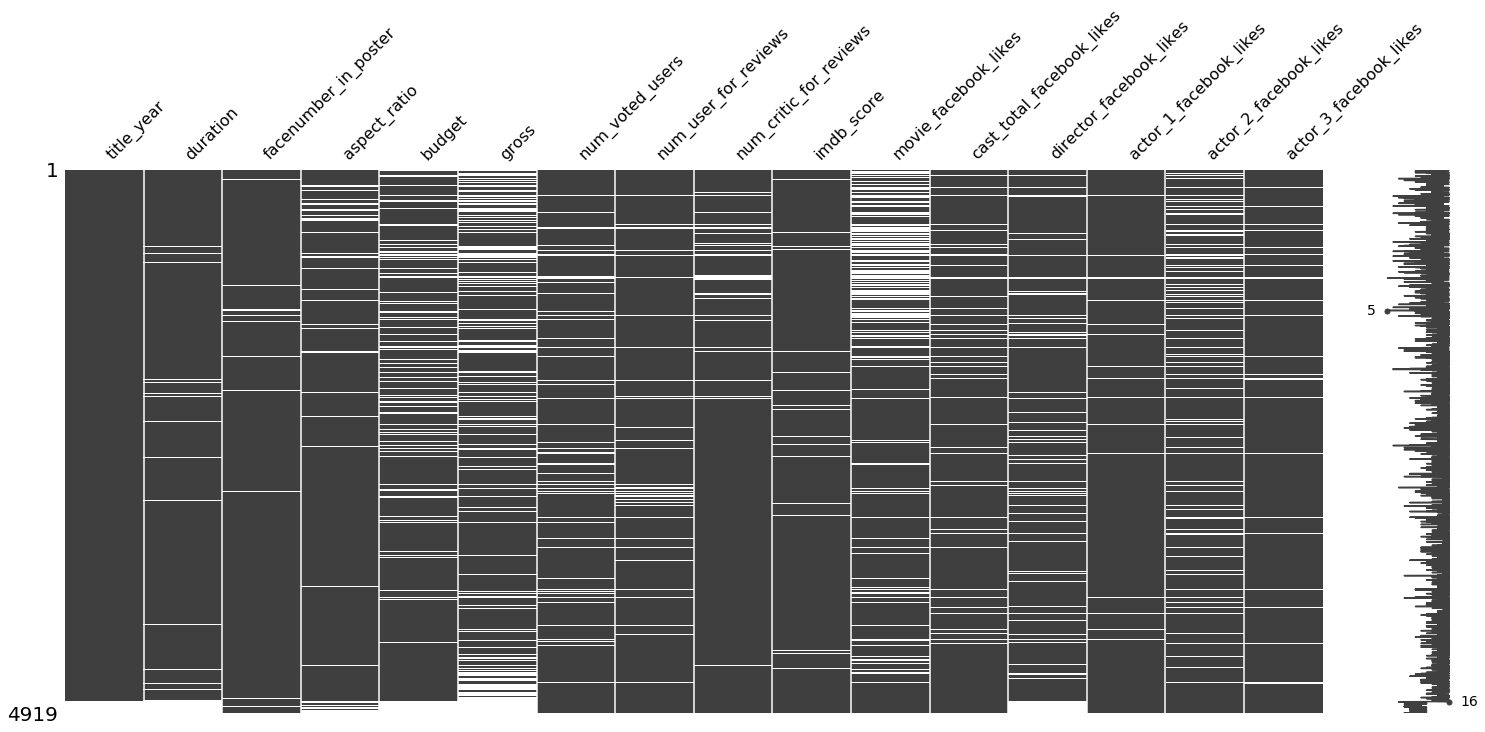

In [43]:
missingdata = num_data.columns[num_data.isnull().any()].tolist()
msno.matrix(num_data[missingdata])
plt.draw()

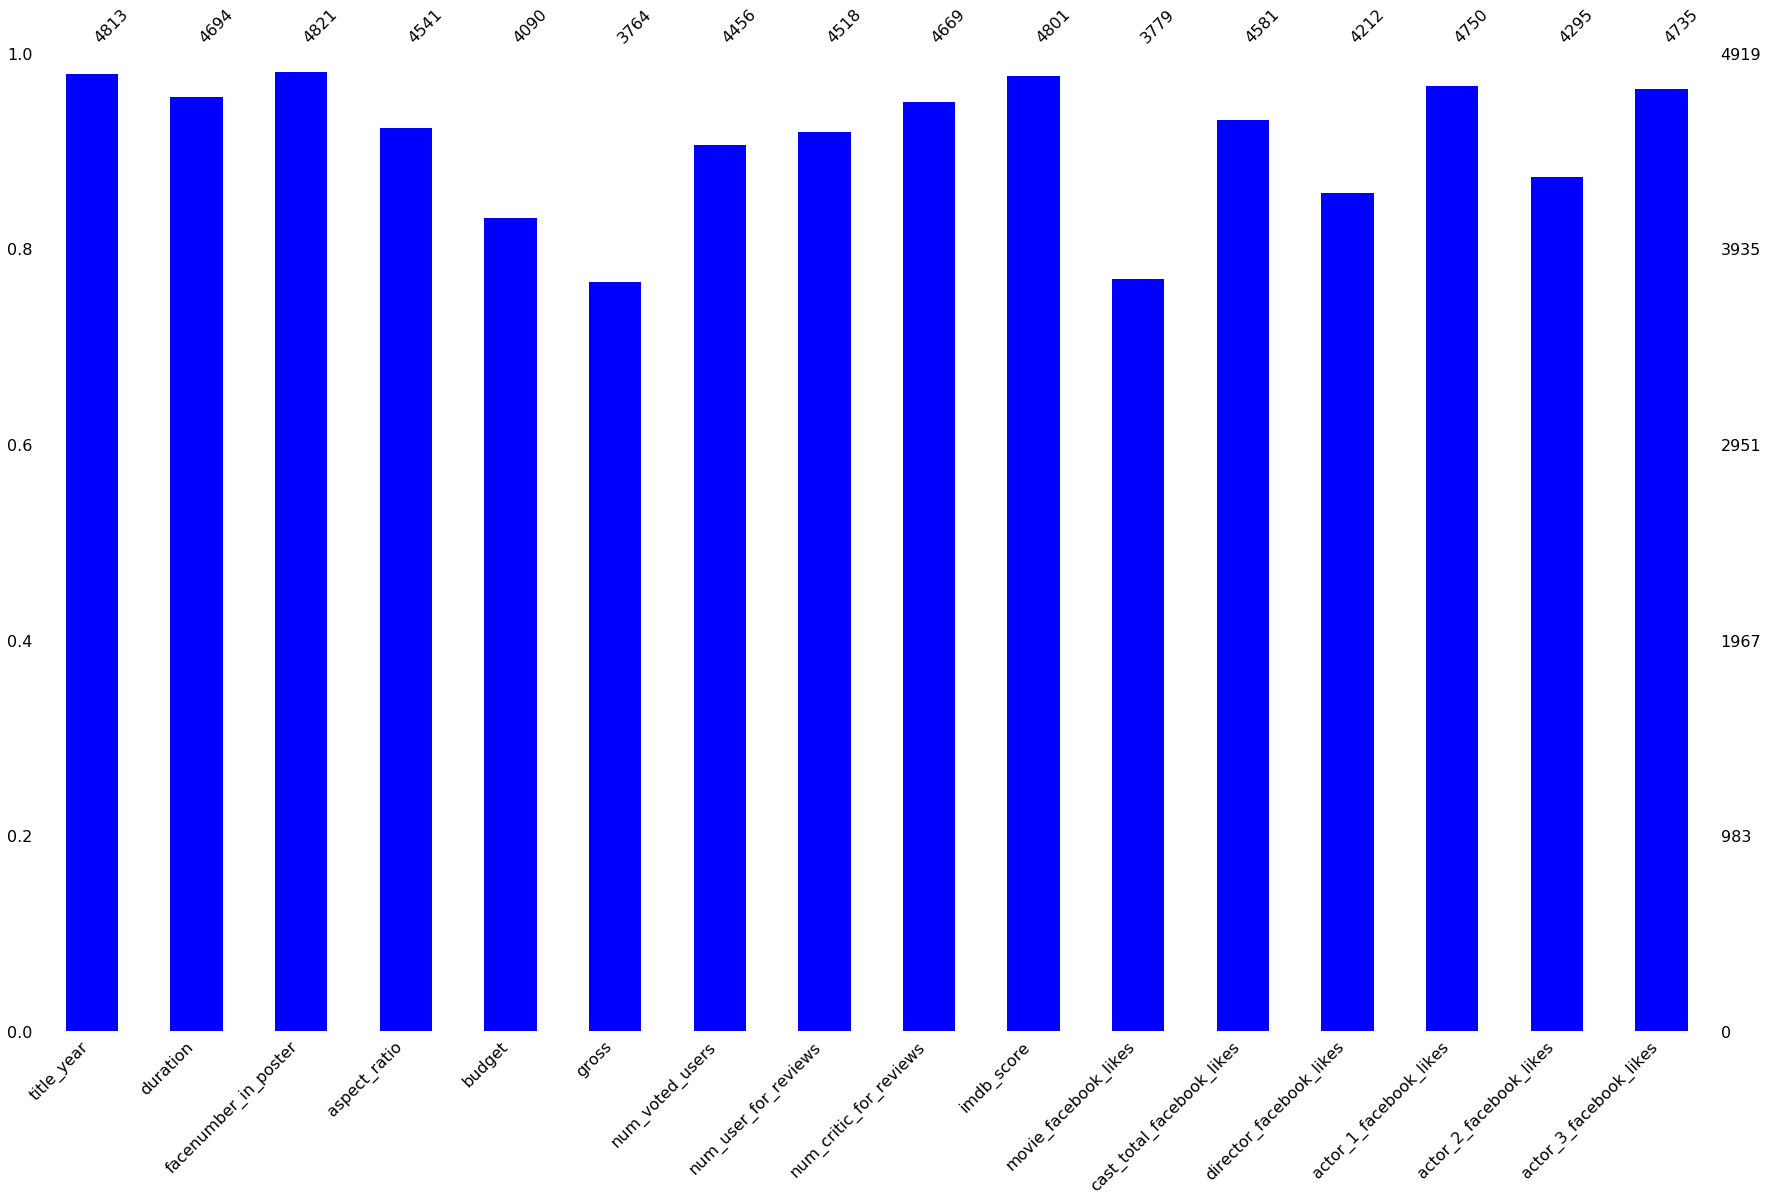

In [44]:
msno.bar(num_data[missingdata], color="blue", figsize=(30,18))
plt.draw()

#### KNN Imputation

In [45]:
# DataFrame without "NaN and Outliers"
num_data_dropna = num_data.copy().dropna()
num_data_dropna.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1760 entries, 3 to 4933
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      1760 non-null   int64  
 1   title_year                 1760 non-null   float64
 2   duration                   1760 non-null   float64
 3   facenumber_in_poster       1760 non-null   float64
 4   aspect_ratio               1760 non-null   float64
 5   budget                     1760 non-null   float64
 6   gross                      1760 non-null   float64
 7   num_voted_users            1760 non-null   float64
 8   num_user_for_reviews       1760 non-null   float64
 9   num_critic_for_reviews     1760 non-null   float64
 10  imdb_score                 1760 non-null   float64
 11  movie_facebook_likes       1760 non-null   float64
 12  cast_total_facebook_likes  1760 non-null   float64
 13  director_facebook_likes    1760 non-null   float

In [46]:
num_data_dropna.shape

(1760, 17)

In [52]:
X = num_data_dropna.iloc[:, 1:17]
y = num_data_dropna.iloc[:,0]

In [53]:
# Séparer training / testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30) #Répartition  70/30 entre training et testing set.

In [54]:
# Feature scaling

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Créer un premier "Classifier" 3-NN
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 3, metric='euclidean')
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test) 

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm


array([[  0,  15],
       [  2, 511]], dtype=int64)

In [55]:
1-classifier.score(X_test, y_test) #Taux d'erreur

0.032196969696969724

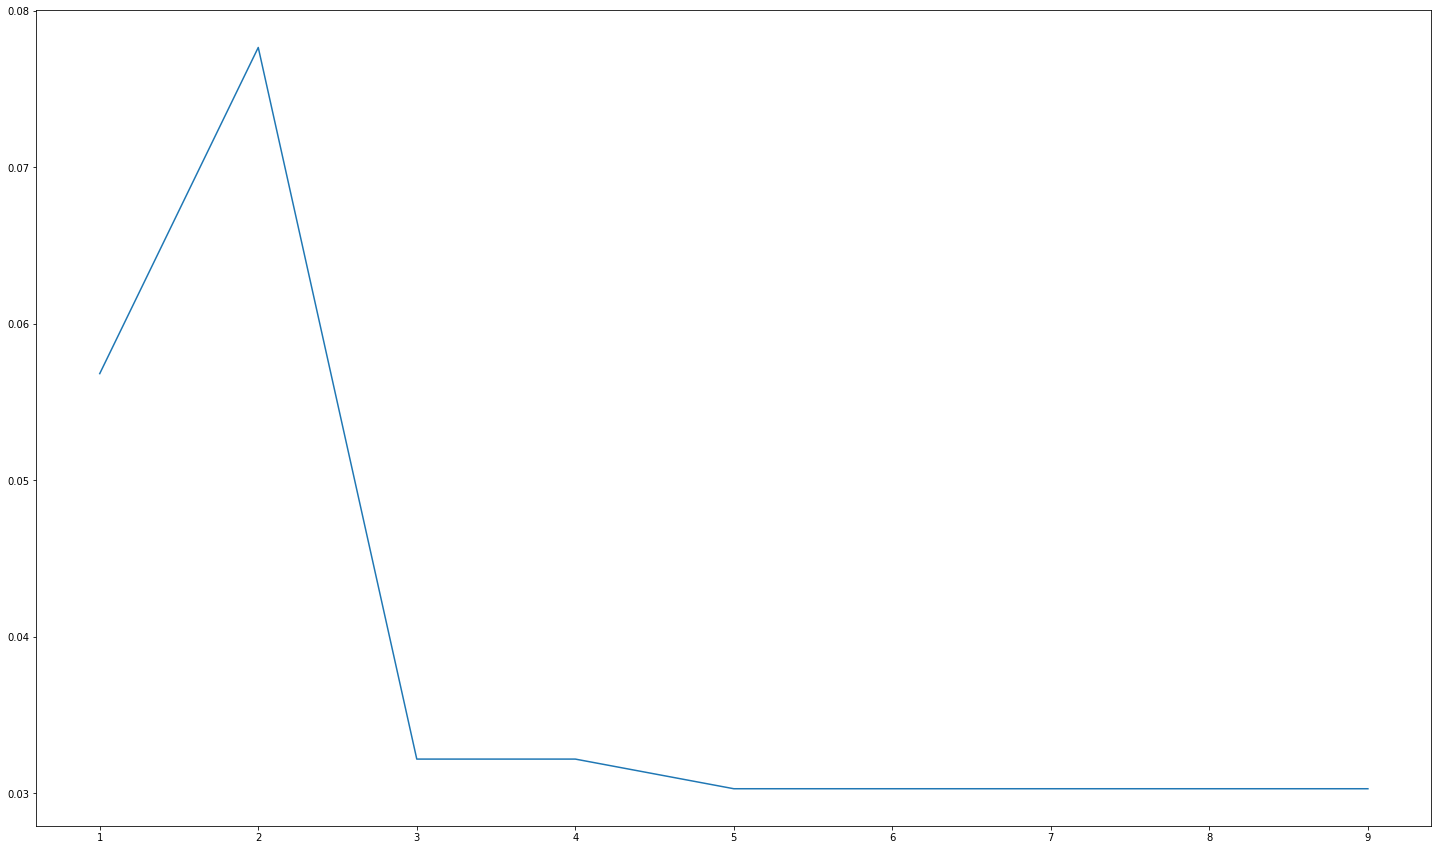

In [56]:
# K optimal (tester le modèle pour les k de 1 à 10)
krange = range(1,10)
errors = []
for k in krange:
    classifier = KNeighborsClassifier(k)
    classifier.fit(X_train, y_train) 
    errors.append(1-classifier.score(X_test, y_test)) #Mesurer l'erreur test
plt.plot(krange, errors) #Afficher la performance en fonction de k
plt.show()

In [57]:
num_data_1 = num_data.iloc[:, 1:17]
num_data_1.head()

,title_year,duration,facenumber_in_poster,aspect_ratio,budget,gross,num_voted_users,num_user_for_reviews,num_critic_for_reviews,imdb_score,movie_facebook_likes,cast_total_facebook_likes,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes
0,2016.0,90.0,4.0,NaN,27000000.0,NaN,60.0,6.0,6.0,5.0,1000.0,2374.0,97.0,731.0,634.0,319.0
1,2016.0,88.0,7.0,NaN,5000000.0,NaN,849.0,4.0,35.0,4.8,0.0,NaN,0.0,NaN,NaN,1000.0
2,2016.0,112.0,0.0,2.35,38000000.0,34912982.0,55617.0,266.0,194.0,5.2,NaN,19974.0,5.0,17000.0,1000.0,724.0
3,2016.0,99.0,1.0,1.85,29000000.0,63034755.0,16984.0,96.0,154.0,5.3,0.0,23562.0,265.0,22000.0,779.0,265.0
4,2016.0,87.0,0.0,1.85,75000000.0,NaN,24407.0,155.0,165.0,6.8,NaN,4782.0,11.0,1000.0,904.0,745.0


In [58]:
num_data_1.shape

(4919, 16)

In [59]:
#KNN Imputation
num_data_imp_NaN = pd.DataFrame(KNN(k=7).fit_transform(num_data_1))

Imputing row 1/4919 with 2 missing, elapsed time: 11.323
Imputing row 101/4919 with 2 missing, elapsed time: 11.340
Imputing row 201/4919 with 1 missing, elapsed time: 11.356
Imputing row 301/4919 with 2 missing, elapsed time: 11.389
Imputing row 401/4919 with 2 missing, elapsed time: 11.406
Imputing row 501/4919 with 2 missing, elapsed time: 11.424
Imputing row 601/4919 with 1 missing, elapsed time: 11.440
Imputing row 701/4919 with 3 missing, elapsed time: 11.457
Imputing row 801/4919 with 4 missing, elapsed time: 11.490
Imputing row 901/4919 with 2 missing, elapsed time: 11.507
Imputing row 1001/4919 with 3 missing, elapsed time: 11.528
Imputing row 1101/4919 with 2 missing, elapsed time: 11.539
Imputing row 1201/4919 with 1 missing, elapsed time: 11.547
Imputing row 1301/4919 with 0 missing, elapsed time: 11.555
Imputing row 1401/4919 with 4 missing, elapsed time: 11.559
Imputing row 1501/4919 with 2 missing, elapsed time: 11.563
Imputing row 1601/4919 with 2 missing, elapsed time:

In [60]:
num_data_imp_NaN.isna().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
dtype: int64

In [61]:
num_data_imp_NaN.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,2016.0,90.0,4.0,1.964755,27000000.0,9.942714e+07,60.0,6.0,6.0,5.0,1000.000000,2374.00000,97.0,731.000000,634.000000,319.0
1,2016.0,88.0,7.0,2.236474,5000000.0,8.949505e+07,849.0,4.0,35.0,4.8,0.000000,19488.49364,0.0,19138.176425,967.336537,1000.0
2,2016.0,112.0,0.0,2.350000,38000000.0,3.491298e+07,55617.0,266.0,194.0,5.2,1152.346519,19974.00000,5.0,17000.000000,1000.000000,724.0
3,2016.0,99.0,1.0,1.850000,29000000.0,6.303476e+07,16984.0,96.0,154.0,5.3,0.000000,23562.00000,265.0,22000.000000,779.000000,265.0
4,2016.0,87.0,0.0,1.850000,75000000.0,1.025690e+08,24407.0,155.0,165.0,6.8,657.594967,4782.00000,11.0,1000.000000,904.000000,745.0


In [62]:
num_data_imp_NaN.columns = ['title_year', 'duration', 'facenumber_in_poster',
'aspect_ratio', 'budget', 'gross', 'num_voted_users', 'num_user_for_reviews', 'num_critic_for_reviews', 'imdb_score', 
'movie_facebook_likes', 'cast_total_facebook_likes', 'director_facebook_likes', 'actor_1_facebook_likes', 
'actor_2_facebook_likes', 'actor_3_facebook_likes'] 

cols = ['title_year', 'duration', 'facenumber_in_poster', 'num_voted_users','num_user_for_reviews', 'num_critic_for_reviews',
        'movie_facebook_likes', 'cast_total_facebook_likes', 'director_facebook_likes', 'actor_1_facebook_likes',
         'actor_2_facebook_likes', 'actor_3_facebook_likes']
num_data_imp_NaN[cols] = num_data_imp_NaN[cols] .applymap(np.int64)
num_data_imp_NaN.head()

,title_year,duration,facenumber_in_poster,aspect_ratio,budget,gross,num_voted_users,num_user_for_reviews,num_critic_for_reviews,imdb_score,movie_facebook_likes,cast_total_facebook_likes,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes
0,2016,90,4,1.964755,27000000.0,9.942714e+07,60,6,6,5.0,1000,2374,97,731,634,319
1,2016,88,7,2.236474,5000000.0,8.949505e+07,849,4,35,4.8,0,19488,0,19138,967,1000
2,2016,112,0,2.350000,38000000.0,3.491298e+07,55617,266,194,5.2,1152,19974,5,17000,1000,724
3,2016,99,1,1.850000,29000000.0,6.303476e+07,16984,96,154,5.3,0,23562,265,22000,779,265
4,2016,87,0,1.850000,75000000.0,1.025690e+08,24407,155,165,6.8,657,4782,11,1000,904,745


In [63]:
num_data_imp_NaN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4919 entries, 0 to 4918
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   title_year                 4919 non-null   int64  
 1   duration                   4919 non-null   int64  
 2   facenumber_in_poster       4919 non-null   int64  
 3   aspect_ratio               4919 non-null   float64
 4   budget                     4919 non-null   float64
 5   gross                      4919 non-null   float64
 6   num_voted_users            4919 non-null   int64  
 7   num_user_for_reviews       4919 non-null   int64  
 8   num_critic_for_reviews     4919 non-null   int64  
 9   imdb_score                 4919 non-null   float64
 10  movie_facebook_likes       4919 non-null   int64  
 11  cast_total_facebook_likes  4919 non-null   int64  
 12  director_facebook_likes    4919 non-null   int64  
 13  actor_1_facebook_likes     4919 non-null   int64

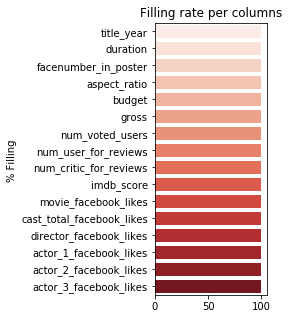

In [64]:
Filling_rate = num_data_imp_NaN.notna().sum().sort_values(ascending=True) / num_data_imp_NaN.shape[0] * 100 
Filling_Plot = Filling_rate[(Filling_rate >= 0) & (Filling_rate <= 100)]
plt.figure(figsize=(2,5))
Filling_percent = sns.barplot(y=Filling_Plot.index.values, x=Filling_Plot.values, palette="Reds")
plt.title("Filling rate per columns")
plt.ylabel("% Filling ")
plt.draw()

#### Visualisation after NaN and Outliers processing

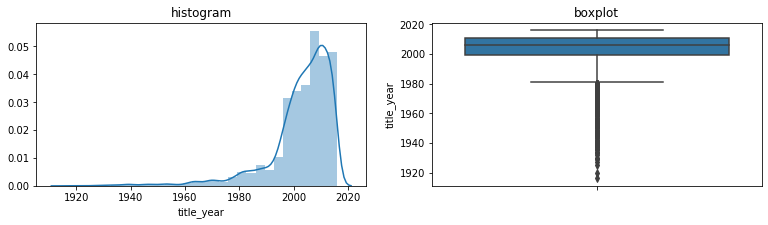

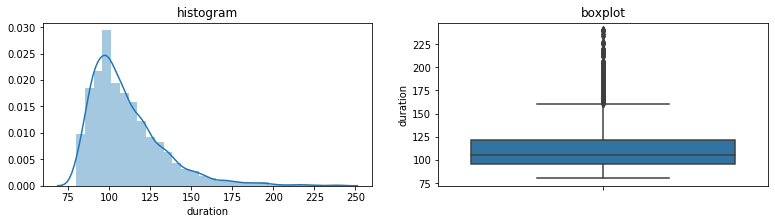

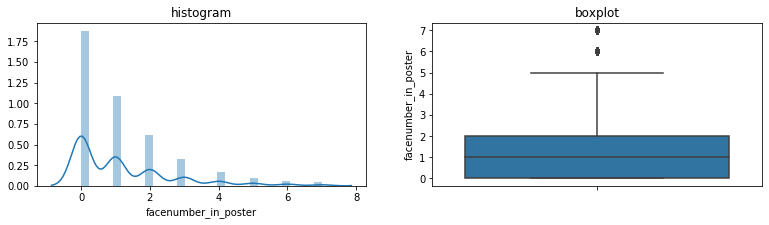

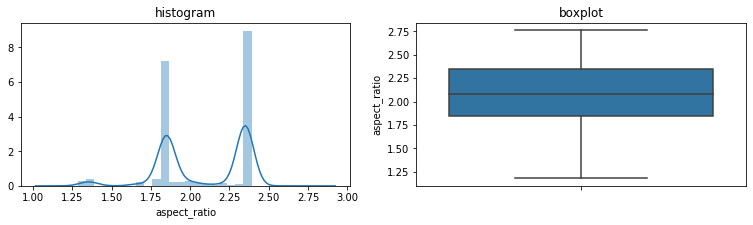

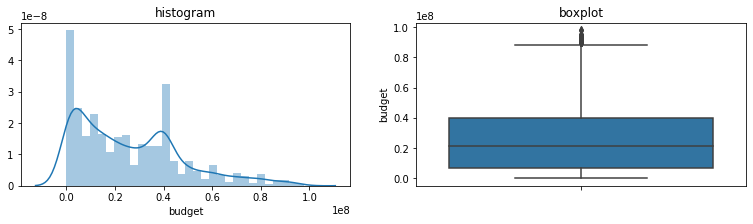

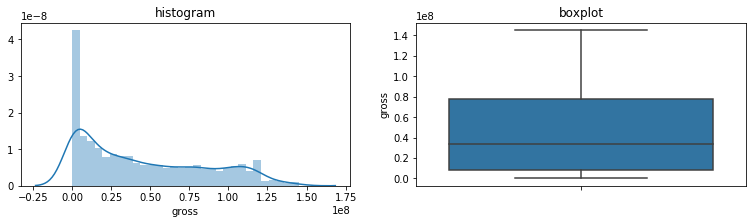

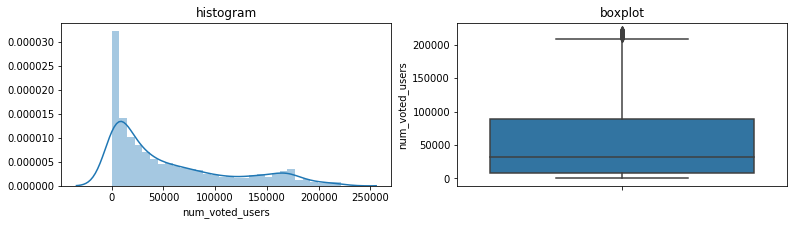

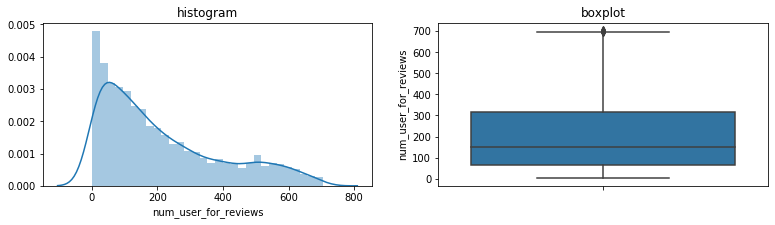

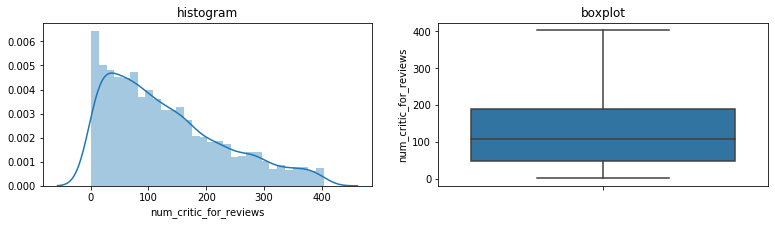

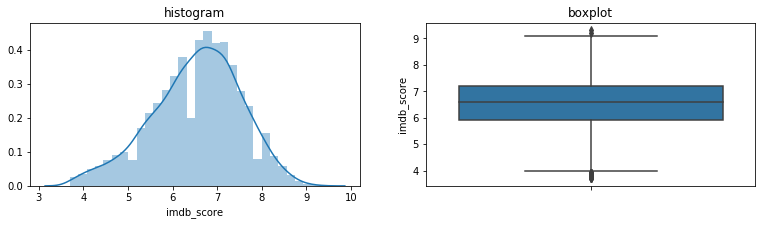

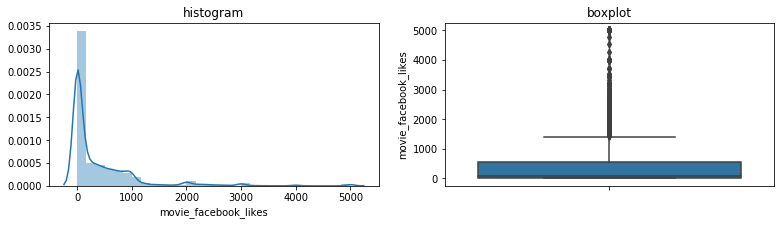

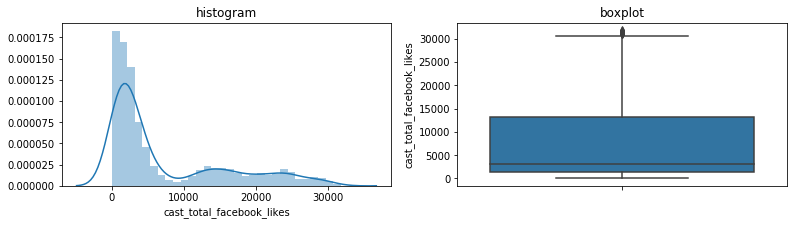

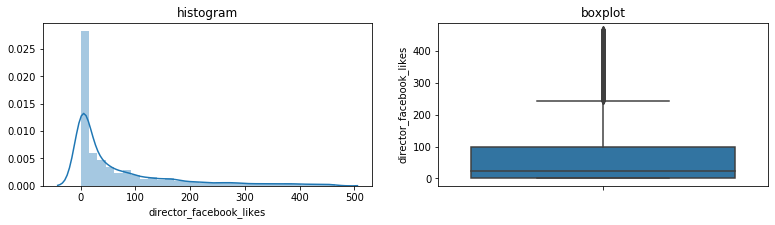

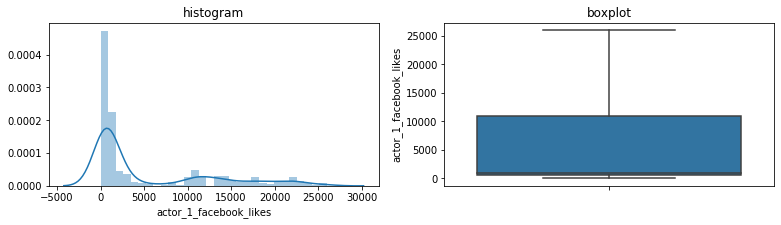

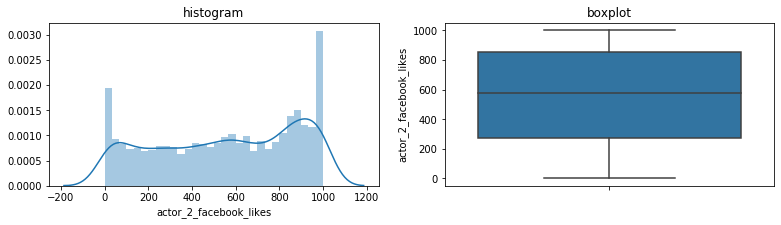

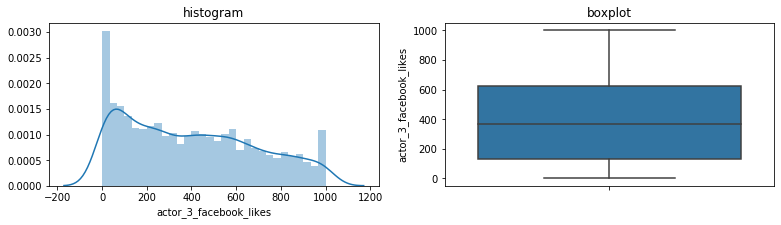

In [65]:
# Movie General Variables
diag_outliers(num_data_imp_NaN, 'title_year')
diag_outliers(num_data_imp_NaN, 'duration')
diag_outliers(num_data_imp_NaN, 'facenumber_in_poster')
diag_outliers(num_data_imp_NaN, 'aspect_ratio')
diag_outliers(num_data_imp_NaN, 'budget')
diag_outliers(num_data_imp_NaN, 'gross')

#Movies Users Variables
diag_outliers(num_data_imp_NaN, 'num_voted_users')
diag_outliers(num_data_imp_NaN, 'num_user_for_reviews')
diag_outliers(num_data_imp_NaN, 'num_critic_for_reviews')
diag_outliers(num_data_imp_NaN, 'imdb_score')

#Movies Facebook Variables
diag_outliers(num_data_imp_NaN, 'movie_facebook_likes')
diag_outliers(num_data_imp_NaN, 'cast_total_facebook_likes')
diag_outliers(num_data_imp_NaN, 'director_facebook_likes')
diag_outliers(num_data_imp_NaN, 'actor_1_facebook_likes')
diag_outliers(num_data_imp_NaN, 'actor_2_facebook_likes')
diag_outliers(num_data_imp_NaN, 'actor_3_facebook_likes')


### 3.3.4 Correlation

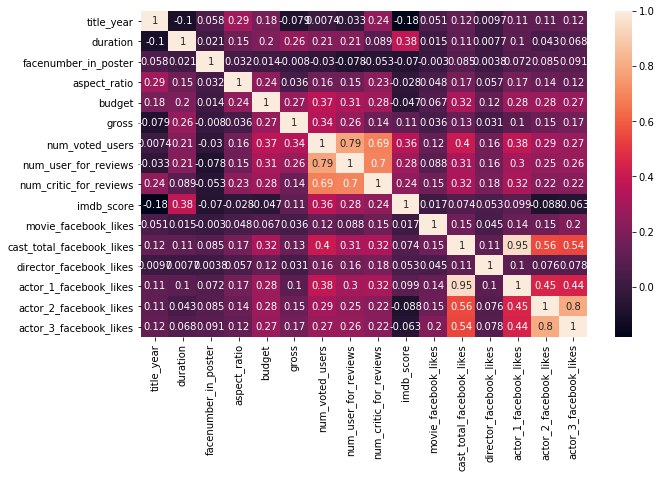

In [66]:
plt.figure(figsize = (10, 6))
sns.heatmap(num_data_imp_NaN.corr(), annot = True)
plt.draw()

In [67]:
#The correlation threshold for removing features r = 0.6

#r('num_critic_for_reviews', 'num_voted_users') = 0.69
#r('num_critic_for_reviews', 'num_user_for_reviews') = 0.7
#r('num_voted_users', 'num_user_for_reviews'  ) = 0.79
#r('actor_2_facebook_likes', 'actor_3_facebook_likes') = 0.8
#r('actor_1_facebook_likes', 'cast_total_facebook_likes') = 0.95


### 3.4 Categorical Variables Processing

In [68]:
#Categorical Variables
objects = ['object']
object_vars = list(movie_data.select_dtypes(include=objects).columns)
data_str = movie_data[object_vars] 
data_str = data_str.reset_index(drop = True)

In [69]:
data_str.head()


,movie_title,genres,country,language,movie_imdb_link,plot_keywords,content_rating,director_name,actor_1_name,actor_2_name,actor_3_name
0,Fight Valley,Action|Drama,USA,English,http://www.imdb.com/title/tt4280822/?ref_=fn_t...,NaN,NaN,Rob Hawk,Kari J. Kramer,Erin O'Brien,Cabrina Collesides
1,Yoga Hosers,Comedy|Fantasy|Horror|Thriller,USA,English,http://www.imdb.com/title/tt3838992/?ref_=fn_t...,part of trilogy|second part,PG-13,Kevin Smith,Johnny Depp,Haley Joel Osment,Natasha Lyonne
2,The 5th Wave,Action|Adventure|Sci-Fi|Thriller,USA,English,http://www.imdb.com/title/tt2304933/?ref_=fn_t...,alien|attack|based on novel|based on young adu...,PG-13,J Blakeson,Chloë Grace Moretz,Maggie Siff,Nick Robinson
3,The Boss,Comedy,USA,English,http://www.imdb.com/title/tt2702724/?ref_=fn_t...,business|girl scouts|orphanage|overweight woma...,R,Ben Falcone,Peter Dinklage,Tyler Labine,Ben Falcone
4,The Secret Life of Pets,Animation|Comedy|Family,Japan,English,http://www.imdb.com/title/tt2709768/?ref_=fn_t...,animal control|lost animal|mongrel|pet|terrier,PG,Yarrow Cheney,Steve Coogan,Eric Stonestreet,Albert Brooks


In [70]:
data_str.shape

(4919, 11)

In [71]:
data_str.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4919 entries, 0 to 4918
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   movie_title      4919 non-null   object
 1   genres           4919 non-null   object
 2   country          4914 non-null   object
 3   language         4907 non-null   object
 4   movie_imdb_link  4919 non-null   object
 5   plot_keywords    4767 non-null   object
 6   content_rating   4618 non-null   object
 7   director_name    4817 non-null   object
 8   actor_1_name     4912 non-null   object
 9   actor_2_name     4906 non-null   object
 10  actor_3_name     4896 non-null   object
dtypes: object(11)
memory usage: 422.9+ KB


#### Country processing

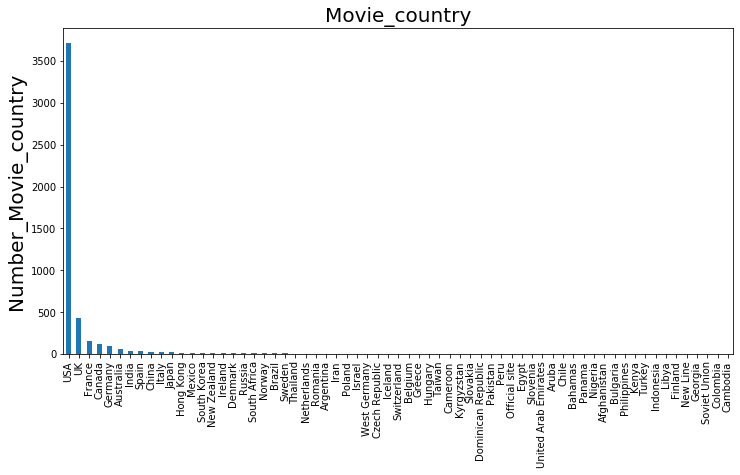

In [72]:
#Country visualisation
plot_country_0 = data_str['country'].value_counts().plot.bar(figsize=(12,6))
plot_country_0.set_title('Movie_country', fontsize=20)
plot_country_0.set_ylabel('Number_Movie_country', fontsize=20)
plt.draw()

In [73]:
# number limitation of coutries
# Digitization of the "country" variable (0 et 1, apply(), map(), applymap())
data_str["country"] = (data_str["country"].map(lambda x: "First" if (x!="USA" and x!="UK" and x!="France") else x))
                        


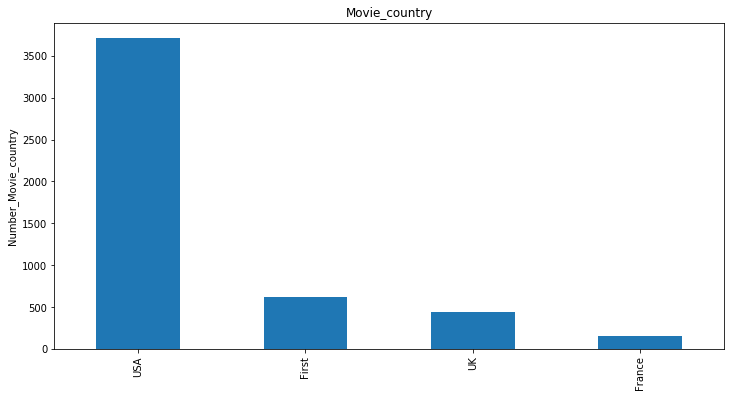

In [74]:
plot_country_1 = data_str['country'].value_counts().plot.bar(figsize=(12,6))
plot_country_1.set_title('Movie_country')
plot_country_1.set_ylabel('Number_Movie_country')
plt.draw()

In [82]:
#data_countries = data_str[["country"]]
#data_countries.head(4)

In [83]:
#Digitization of the "country" variable
tmp_0 = pd.concat([data_str["country"], pd.get_dummies(data_str["country"], drop_first=True)], axis=1)
tmp_0.head() 

,country,France,UK,USA
0,USA,0,0,1
1,USA,0,0,1
2,USA,0,0,1
3,USA,0,0,1
4,First,0,0,0


In [84]:
# Deletion of the variable "country"
data_str = pd.concat([data_str, tmp_0], axis = 1)
del data_str['country']
data_str.head(3)

,movie_title,genres,language,movie_imdb_link,plot_keywords,content_rating,director_name,actor_1_name,actor_2_name,actor_3_name,France,UK,USA
0,Fight Valley,Action|Drama,English,http://www.imdb.com/title/tt4280822/?ref_=fn_t...,NaN,NaN,Rob Hawk,Kari J. Kramer,Erin O'Brien,Cabrina Collesides,0,0,1
1,Yoga Hosers,Comedy|Fantasy|Horror|Thriller,English,http://www.imdb.com/title/tt3838992/?ref_=fn_t...,part of trilogy|second part,PG-13,Kevin Smith,Johnny Depp,Haley Joel Osment,Natasha Lyonne,0,0,1
2,The 5th Wave,Action|Adventure|Sci-Fi|Thriller,English,http://www.imdb.com/title/tt2304933/?ref_=fn_t...,alien|attack|based on novel|based on young adu...,PG-13,J Blakeson,Chloë Grace Moretz,Maggie Siff,Nick Robinson,0,0,1


#### Language processing

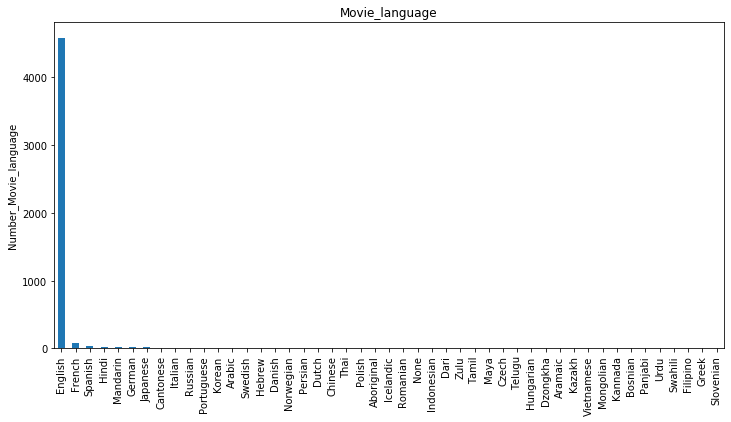

In [85]:
# language visualisation
plot_language_0 = data_str['language'].value_counts().plot.bar(figsize=(12,6))
plot_language_0.set_title('Movie_language')
plot_language_0.set_ylabel('Number_Movie_language')
plt.draw()

In [86]:
# number limitation of languages
data_str["language"] = (data_str["language"].map(lambda x: "A" if (x!="English" and x!="French") else x))        

In [87]:
data_str[["language"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4919 entries, 0 to 4918
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   language  4919 non-null   object
dtypes: object(1)
memory usage: 38.6+ KB


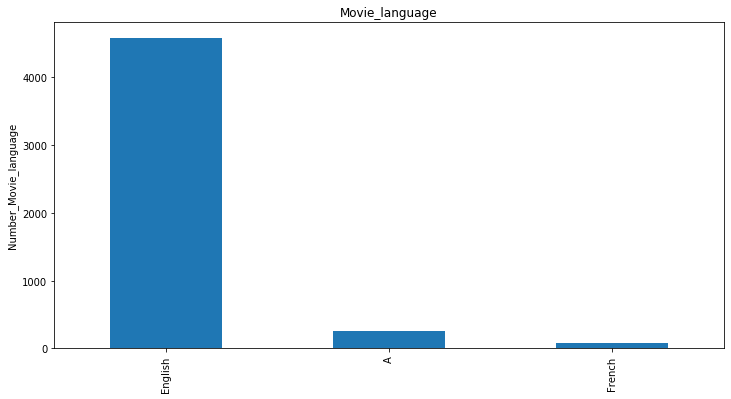

In [88]:
# language visualisation
plot_language_1 = data_str['language'].value_counts().plot.bar(figsize=(12,6))
plot_language_1.set_title('Movie_language')
plot_language_1.set_ylabel('Number_Movie_language')
plt.draw()

In [89]:
# Digitalisation of the "language" variable
tmp_1 = pd.concat([data_str["language"], pd.get_dummies(data_str["language"], drop_first=True)], axis=1)
tmp_1.head()  

,language,English,French
0,English,1,0
1,English,1,0
2,English,1,0
3,English,1,0
4,English,1,0


In [90]:
# Deletion of the variable "language"
data_str = pd.concat([data_str, tmp_1], axis = 1)
del data_str['language']
data_str.head(3)

,movie_title,genres,movie_imdb_link,plot_keywords,content_rating,director_name,actor_1_name,actor_2_name,actor_3_name,France,UK,USA,English,French
0,Fight Valley,Action|Drama,http://www.imdb.com/title/tt4280822/?ref_=fn_t...,NaN,NaN,Rob Hawk,Kari J. Kramer,Erin O'Brien,Cabrina Collesides,0,0,1,1,0
1,Yoga Hosers,Comedy|Fantasy|Horror|Thriller,http://www.imdb.com/title/tt3838992/?ref_=fn_t...,part of trilogy|second part,PG-13,Kevin Smith,Johnny Depp,Haley Joel Osment,Natasha Lyonne,0,0,1,1,0
2,The 5th Wave,Action|Adventure|Sci-Fi|Thriller,http://www.imdb.com/title/tt2304933/?ref_=fn_t...,alien|attack|based on novel|based on young adu...,PG-13,J Blakeson,Chloë Grace Moretz,Maggie Siff,Nick Robinson,0,0,1,1,0


#### genres processing

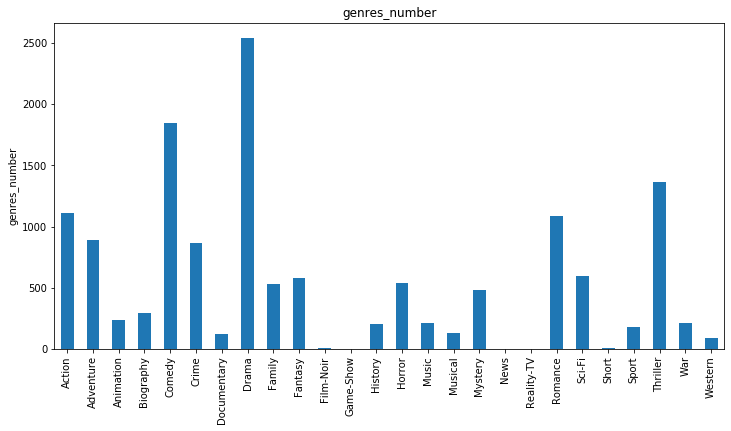

In [91]:
# genres visualisation
plot_genres_0 = data_str['genres'].str.split('|', expand=True).stack().str.get_dummies().sum().plot.bar(figsize=(12,6)) #...'expand' créer df de 7 variables genres, 
plot_genres_0.set_title('genres_number')
plot_genres_0.set_ylabel('genres_number')
plt.draw()

In [92]:
# Digitalization of the "genres" variable
tmp_2 = pd.concat([data_str["genres"], data_str["genres"].str.get_dummies('|')], axis=1)
tmp_2.head()

,genres,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,Action|Drama,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,Comedy|Fantasy|Horror|Thriller,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,Action|Adventure|Sci-Fi|Thriller,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,Comedy,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Animation|Comedy|Family,0,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [93]:
# Deletion of the variable "genres" and the last column
data_str = pd.concat([data_str, tmp_2], axis = 1)
del data_str['genres']
#del data_str['Western']
data_str.head(3)

,movie_title,movie_imdb_link,plot_keywords,content_rating,director_name,actor_1_name,actor_2_name,actor_3_name,France,UK,...,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,Fight Valley,http://www.imdb.com/title/tt4280822/?ref_=fn_t...,NaN,NaN,Rob Hawk,Kari J. Kramer,Erin O'Brien,Cabrina Collesides,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Yoga Hosers,http://www.imdb.com/title/tt3838992/?ref_=fn_t...,part of trilogy|second part,PG-13,Kevin Smith,Johnny Depp,Haley Joel Osment,Natasha Lyonne,0,0,...,0,0,0,0,0,0,0,1,0,0
2,The 5th Wave,http://www.imdb.com/title/tt2304933/?ref_=fn_t...,alien|attack|based on novel|based on young adu...,PG-13,J Blakeson,Chloë Grace Moretz,Maggie Siff,Nick Robinson,0,0,...,0,0,0,0,1,0,0,1,0,0


#### content_rating processing

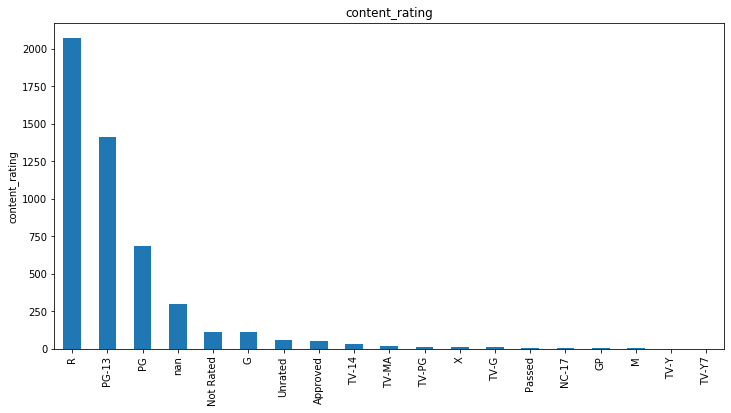

In [94]:
#content_rating visualisation
plot_content_rating_0 = data_str['content_rating'].value_counts(dropna = False).plot.bar(figsize=(12,6))
plot_content_rating_0.set_title('content_rating')
plot_content_rating_0.set_ylabel('content_rating')
plt.draw()

#R : Restricted, Under 17 requires accompanying parent or adult guardian. Contains some adult material. Parents are urged to learn more about the film before taking their young children with them.
#PG-13 : Parents Strongly Cautioned
#PG : Parental Guidance Suggested
#G : General Audiences
#TV-14 : This program contains some material that many parents would find unsuitable for children under 14 years of age
#TV-MA : This program is specifically designed to be viewed by adults and therefore may be unsuitable for children under 17
#TV-PG : This program contains material that parents may find unsuitable for younger children
#X = NC-17 : Adults Only
#TV-G : suitable for all ages
#NC-17 :  Adults Only
#GP = PG = M : Parental Guidance Suggested
#M = PG = GP : Parental Guidance Suggested
#TV-Y : This program is designed to be appropriate for all children
#TV-Y7 : This program is designed for children age 7 and above
#NaN, Not Rated, Unrated, Approved, Passed, seront remplacés par la majorité "R"

#### reduction of classes

#R = NaN = Not Rated = Unrated = Approved = Passed
#PG-13 = TV-14
#PG = GP = M = TV-PG
#G = TV-G = TV-Y = TV-Y7
#NC-17 = TV-MA = X
Les classes à gardées: R, G, PG, PG-13, NC-17

In [95]:
data_str["content_rating"] = (data_str["content_rating"].
                              apply(lambda x: 'R' if (x=='Not Rated' or x=='Unrated' or x=='Approved' or x=='Passed') else x)) 
                              

In [96]:
data_str["content_rating"] = data_str["content_rating"].replace('TV-14', 'PG-13')
                             #.apply(lambda x: 'R' if (x=='Not Rated' or x=='Unrated' or x=='Approved' or x=='Passed') else x

In [97]:
data_str["content_rating"] = data_str["content_rating"].apply(lambda x:'PG' if (x=='GP' or x=='M' or x=='TV-PG') else x)

In [98]:
data_str["content_rating"] = data_str["content_rating"].apply(lambda x:'NC-17' if (x=='TV-MA' or x=='X') else x)

In [99]:
data_str["content_rating"] = data_str["content_rating"].apply(lambda x:'G' if (x=='TV-G' or x=='TV-Y' or x=='TV-Y7') else x)

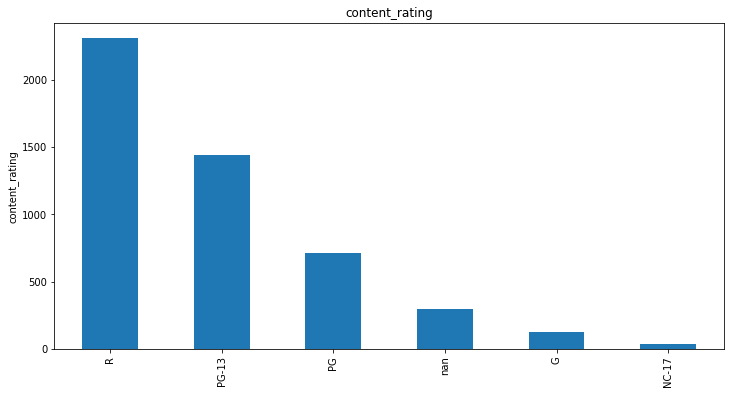

In [100]:
# content_rating visualisation
plot_content_rating_1 = data_str['content_rating'].value_counts(dropna = False).plot.bar(figsize=(12,6))
plot_content_rating_1.set_title('content_rating')
plot_content_rating_1.set_ylabel('content_rating')
plt.draw()

In [101]:
#Digitization of the "content_rating" variable and  deletion the last column
ohe_enc = OneHotCategoricalEncoder(
    top_categories=None,
    variables=['content_rating'],
    drop_last=False)
ohe_enc.fit(data_str)

OneHotCategoricalEncoder(drop_last=False, top_categories=None,
                         variables=['content_rating'])

In [102]:
data_str = ohe_enc.transform(data_str)
del(data_str["content_rating_nan"])
data_str.head()

,movie_title,movie_imdb_link,plot_keywords,director_name,actor_1_name,actor_2_name,actor_3_name,France,UK,USA,...,Short,Sport,Thriller,War,Western,content_rating_PG-13,content_rating_R,content_rating_PG,content_rating_G,content_rating_NC-17
0,Fight Valley,http://www.imdb.com/title/tt4280822/?ref_=fn_t...,NaN,Rob Hawk,Kari J. Kramer,Erin O'Brien,Cabrina Collesides,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,Yoga Hosers,http://www.imdb.com/title/tt3838992/?ref_=fn_t...,part of trilogy|second part,Kevin Smith,Johnny Depp,Haley Joel Osment,Natasha Lyonne,0,0,1,...,0,0,1,0,0,1,0,0,0,0
2,The 5th Wave,http://www.imdb.com/title/tt2304933/?ref_=fn_t...,alien|attack|based on novel|based on young adu...,J Blakeson,Chloë Grace Moretz,Maggie Siff,Nick Robinson,0,0,1,...,0,0,1,0,0,1,0,0,0,0
3,The Boss,http://www.imdb.com/title/tt2702724/?ref_=fn_t...,business|girl scouts|orphanage|overweight woma...,Ben Falcone,Peter Dinklage,Tyler Labine,Ben Falcone,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,The Secret Life of Pets,http://www.imdb.com/title/tt2709768/?ref_=fn_t...,animal control|lost animal|mongrel|pet|terrier,Yarrow Cheney,Steve Coogan,Eric Stonestreet,Albert Brooks,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [103]:
print(num_data_imp_NaN.shape)
print(data_str.shape)

(4919, 16)
(4919, 43)


In [104]:
movie_data_1 = pd.concat([data_str, num_data_imp_NaN], axis = 1)
movie_data_1.head()

,movie_title,movie_imdb_link,plot_keywords,director_name,actor_1_name,actor_2_name,actor_3_name,France,UK,USA,...,num_voted_users,num_user_for_reviews,num_critic_for_reviews,imdb_score,movie_facebook_likes,cast_total_facebook_likes,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes
0,Fight Valley,http://www.imdb.com/title/tt4280822/?ref_=fn_t...,NaN,Rob Hawk,Kari J. Kramer,Erin O'Brien,Cabrina Collesides,0,0,1,...,60,6,6,5.0,1000,2374,97,731,634,319
1,Yoga Hosers,http://www.imdb.com/title/tt3838992/?ref_=fn_t...,part of trilogy|second part,Kevin Smith,Johnny Depp,Haley Joel Osment,Natasha Lyonne,0,0,1,...,849,4,35,4.8,0,19488,0,19138,967,1000
2,The 5th Wave,http://www.imdb.com/title/tt2304933/?ref_=fn_t...,alien|attack|based on novel|based on young adu...,J Blakeson,Chloë Grace Moretz,Maggie Siff,Nick Robinson,0,0,1,...,55617,266,194,5.2,1152,19974,5,17000,1000,724
3,The Boss,http://www.imdb.com/title/tt2702724/?ref_=fn_t...,business|girl scouts|orphanage|overweight woma...,Ben Falcone,Peter Dinklage,Tyler Labine,Ben Falcone,0,0,1,...,16984,96,154,5.3,0,23562,265,22000,779,265
4,The Secret Life of Pets,http://www.imdb.com/title/tt2709768/?ref_=fn_t...,animal control|lost animal|mongrel|pet|terrier,Yarrow Cheney,Steve Coogan,Eric Stonestreet,Albert Brooks,0,0,0,...,24407,155,165,6.8,657,4782,11,1000,904,745


In [105]:
movie_data_1["plot_keywords"]

0                                                     NaN
1                             part of trilogy|second part
2       alien|attack|based on novel|based on young adu...
3       business|girl scouts|orphanage|overweight woma...
4          animal control|lost animal|mongrel|pet|terrier
                              ...                        
4914    father daughter relationship|serial killer|sup...
4915                 coach|friend|school|series|tv series
4916    2020s|near future|one word series title|post a...
4917    caravan|police|police sergeant|tied to a chair...
4918         cult|fbi|hideout|prison escape|serial killer
Name: plot_keywords, Length: 4919, dtype: object

In [ ]:
# Del "plot_keywords" : difficult to operate

In [106]:
movie_data_1.drop(["movie_imdb_link", "plot_keywords"], axis=1, inplace=True)
movie_data_1.head()

,movie_title,director_name,actor_1_name,actor_2_name,actor_3_name,France,UK,USA,English,French,...,num_voted_users,num_user_for_reviews,num_critic_for_reviews,imdb_score,movie_facebook_likes,cast_total_facebook_likes,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes
0,Fight Valley,Rob Hawk,Kari J. Kramer,Erin O'Brien,Cabrina Collesides,0,0,1,1,0,...,60,6,6,5.0,1000,2374,97,731,634,319
1,Yoga Hosers,Kevin Smith,Johnny Depp,Haley Joel Osment,Natasha Lyonne,0,0,1,1,0,...,849,4,35,4.8,0,19488,0,19138,967,1000
2,The 5th Wave,J Blakeson,Chloë Grace Moretz,Maggie Siff,Nick Robinson,0,0,1,1,0,...,55617,266,194,5.2,1152,19974,5,17000,1000,724
3,The Boss,Ben Falcone,Peter Dinklage,Tyler Labine,Ben Falcone,0,0,1,1,0,...,16984,96,154,5.3,0,23562,265,22000,779,265
4,The Secret Life of Pets,Yarrow Cheney,Steve Coogan,Eric Stonestreet,Albert Brooks,0,0,0,1,0,...,24407,155,165,6.8,657,4782,11,1000,904,745


In [107]:
movie_data_1.shape

(4919, 57)

In [108]:
movie_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4919 entries, 0 to 4918
Data columns (total 57 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   movie_title                4919 non-null   object 
 1   director_name              4817 non-null   object 
 2   actor_1_name               4912 non-null   object 
 3   actor_2_name               4906 non-null   object 
 4   actor_3_name               4896 non-null   object 
 5   France                     4919 non-null   uint8  
 6   UK                         4919 non-null   uint8  
 7   USA                        4919 non-null   uint8  
 8   English                    4919 non-null   uint8  
 9   French                     4919 non-null   uint8  
 10  Action                     4919 non-null   int64  
 11  Adventure                  4919 non-null   int64  
 12  Animation                  4919 non-null   int64  
 13  Biography                  4919 non-null   int64

In [109]:
movie_data_1.dropna(axis=0, inplace = True )
movie_data_1.head()

,movie_title,director_name,actor_1_name,actor_2_name,actor_3_name,France,UK,USA,English,French,...,num_voted_users,num_user_for_reviews,num_critic_for_reviews,imdb_score,movie_facebook_likes,cast_total_facebook_likes,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes
0,Fight Valley,Rob Hawk,Kari J. Kramer,Erin O'Brien,Cabrina Collesides,0,0,1,1,0,...,60,6,6,5.0,1000,2374,97,731,634,319
1,Yoga Hosers,Kevin Smith,Johnny Depp,Haley Joel Osment,Natasha Lyonne,0,0,1,1,0,...,849,4,35,4.8,0,19488,0,19138,967,1000
2,The 5th Wave,J Blakeson,Chloë Grace Moretz,Maggie Siff,Nick Robinson,0,0,1,1,0,...,55617,266,194,5.2,1152,19974,5,17000,1000,724
3,The Boss,Ben Falcone,Peter Dinklage,Tyler Labine,Ben Falcone,0,0,1,1,0,...,16984,96,154,5.3,0,23562,265,22000,779,265
4,The Secret Life of Pets,Yarrow Cheney,Steve Coogan,Eric Stonestreet,Albert Brooks,0,0,0,1,0,...,24407,155,165,6.8,657,4782,11,1000,904,745


In [110]:
movie_data_1.shape

(4797, 57)

#### Movie Staff Processing

In [ ]:
# Keep the directors and the actors who appear at least twice
#Apply OneHotEncoding

In [111]:
#staff_1.colums = ['director', 'actor_1', 'actor_2', 'actor_3']
#staff_1.head()
movie_data_1 = movie_data_1.rename(columns={"director_name": "director", "actor_1_name": "actor1", "actor_2_name": "actor2", "actor_3_name": "actor3"})
movie_data_1.head()

,movie_title,director,actor1,actor2,actor3,France,UK,USA,English,French,...,num_voted_users,num_user_for_reviews,num_critic_for_reviews,imdb_score,movie_facebook_likes,cast_total_facebook_likes,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes
0,Fight Valley,Rob Hawk,Kari J. Kramer,Erin O'Brien,Cabrina Collesides,0,0,1,1,0,...,60,6,6,5.0,1000,2374,97,731,634,319
1,Yoga Hosers,Kevin Smith,Johnny Depp,Haley Joel Osment,Natasha Lyonne,0,0,1,1,0,...,849,4,35,4.8,0,19488,0,19138,967,1000
2,The 5th Wave,J Blakeson,Chloë Grace Moretz,Maggie Siff,Nick Robinson,0,0,1,1,0,...,55617,266,194,5.2,1152,19974,5,17000,1000,724
3,The Boss,Ben Falcone,Peter Dinklage,Tyler Labine,Ben Falcone,0,0,1,1,0,...,16984,96,154,5.3,0,23562,265,22000,779,265
4,The Secret Life of Pets,Yarrow Cheney,Steve Coogan,Eric Stonestreet,Albert Brooks,0,0,0,1,0,...,24407,155,165,6.8,657,4782,11,1000,904,745


In [112]:
staff_0 = movie_data_1.iloc[:, 1:5]
staff_0.head()

,director,actor1,actor2,actor3
0,Rob Hawk,Kari J. Kramer,Erin O'Brien,Cabrina Collesides
1,Kevin Smith,Johnny Depp,Haley Joel Osment,Natasha Lyonne
2,J Blakeson,Chloë Grace Moretz,Maggie Siff,Nick Robinson
3,Ben Falcone,Peter Dinklage,Tyler Labine,Ben Falcone
4,Yarrow Cheney,Steve Coogan,Eric Stonestreet,Albert Brooks


In [114]:
unique,counts=np.unique(staff_0,return_counts=True)
staff_0_occu = unique,counts
staff_0_occu

(array(['50 Cent', 'A. Michael Baldwin', 'A. Raven Cruz', ...,
        'Éric Tessier', 'Étienne Faure', 'Óscar Jaenada'], dtype=object),
 array([5, 1, 1, ..., 1, 1, 3], dtype=int64))

In [115]:
len(unique)

8332

In [116]:
staff_0_occu=pd.DataFrame(staff_0_occu).T
staff_0_occu.columns = ['name', 'Occurrence']   
staff_0_occu.head()

,name,Occurrence
0,50 Cent,5
1,A. Michael Baldwin,1
2,A. Raven Cruz,1
3,A.J. Buckley,5
4,A.J. DeLucia,1


In [117]:
staff_0_occu=staff_0_occu.sort_values(by = 'Occurrence', ascending = True)
staff_0_occu.head()

,name,Occurrence
7485,Stuart Gillard,1
4144,Judith Godrèche,1
4143,Judith Chapman,1
4140,Judie Aronson,1
7247,Shigeo Kobayashi,1


In [118]:
staff_0_occu=staff_0_occu.reset_index(drop = True)
staff_0_occu.head()

,name,Occurrence
0,Stuart Gillard,1
1,Judith Godrèche,1
2,Judith Chapman,1
3,Judie Aronson,1
4,Shigeo Kobayashi,1


In [119]:
staff_0_occu['Occurrence'].value_counts().head()

1    5199
2    1283
3     558
4     359
5     257
Name: Occurrence, dtype: int64

In [120]:
staff_0_occu_1 = staff_0_occu.iloc[0:5199,0]
staff_0_occu_1.head()

0      Stuart Gillard
1     Judith Godrèche
2      Judith Chapman
3       Judie Aronson
4    Shigeo Kobayashi
Name: name, dtype: object

In [121]:
staff_0_occu_1.shape

(5199,)

In [122]:
list_unique = staff_0_occu_1.values.tolist()
list_unique

['Stuart Gillard',
 'Judith Godrèche',
 'Judith Chapman',
 'Judie Aronson',
 'Shigeo Kobayashi',
 'Jude Ciccolella',
 'Shimit Amin',
 "Shin'ya Tsukamoto",
 'Jud Tylor',
 'Judith Hill',
 'Juan Riedinger',
 'Juan Fernández',
 'Juan Carlos Montoya',
 'Juan Carlos Fresnadillo',
 'Jsu Garcia',
 'Joyful Drake',
 'Joyce Van Patten',
 'Joy Bryant',
 'José Wilker',
 'Juan Luis Galiardo',
 "Judith O'Dea",
 'Shidô Nakamura',
 'Sheryl Lee',
 'Juliane Köhler',
 'Shengyi Huang',
 'Sheridan Smith',
 'Sherman Alexie',
 'Julian Kostov',
 'Étienne Faure',
 'Sherman Hemsley',
 'Julian Fellowes',
 'Julia Taylor Ross',
 'Julia Sawalha',
 'Sherri Shepherd',
 'Julia Nickson',
 'Julia Jones',
 'Julia Jentsch',
 'Julia Garner',
 'Julia Duffy',
 'Julene Renee',
 'Juhi Chawla',
 'Jugal Hansraj',
 'José Manuel Orozco Angulo',
 'Julianna Guill',
 'José Luis Valenzuela',
 'Jossara Jinaro',
 'Joseph Sargent',
 'Joseph Ruben',
 'Joseph Pilato',
 'Joseph Mazzella',
 'Joseph Mawle',
 'Joseph Mascolo',
 'Joseph L. Manki

In [123]:
actor_1 = movie_data_1.iloc[:, 2:3]
actor_1.head()

,actor1
0,Kari J. Kramer
1,Johnny Depp
2,Chloë Grace Moretz
3,Peter Dinklage
4,Steve Coogan


In [124]:
len(actor_1['actor1'].unique())

2034

In [125]:
ohe_enc_1 = OneHotCategoricalEncoder(
    top_categories=None,
    variables=['actor1'],
    drop_last=False)

ohe_enc_1.fit(actor_1)

OneHotCategoricalEncoder(drop_last=False, top_categories=None,
                         variables=['actor1'])

In [126]:
actor_1 = ohe_enc_1.transform(actor_1)
actor_1.columns= actor_1.columns.str.replace("actor1_", "")
actor_1.head()

,Kari J. Kramer,Johnny Depp,Chloë Grace Moretz,Peter Dinklage,Steve Coogan,Daniel Radcliffe,Dominic Cooper,Bryce Dallas Howard,Dwayne Johnson,Scott Takeda,...,Ginger Rogers,Claudette Colbert,Mae West,Jean Harlow,Anita Page,Louise Brooks,Brigitte Helm,John Gilbert,Stephen Carr,Lillian Gish
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [127]:
actor_1.shape

(4797, 2034)

In [128]:
actor_2 = movie_data_1.iloc[:, 3:4]
actor_2.head()

,actor2
0,Erin O'Brien
1,Haley Joel Osment
2,Maggie Siff
3,Tyler Labine
4,Eric Stonestreet


In [129]:
len(actor_2['actor2'].unique())

2957

In [130]:
ohe_enc_2 = OneHotCategoricalEncoder(
    top_categories=None,
    variables=['actor2'],
    drop_last=False)

ohe_enc_2.fit(actor_2)

OneHotCategoricalEncoder(drop_last=False, top_categories=None,
                         variables=['actor2'])

In [131]:
actor_2 = ohe_enc_2.transform(actor_2)
actor_2.columns = actor_2.columns.str.replace("actor2_", "")
actor_2.head()

,Erin O'Brien,Haley Joel Osment,Maggie Siff,Tyler Labine,Eric Stonestreet,Morgan Freeman,Callum Rennie,Alan Rickman,Oona Laurence,Thomas Kretschmann,...,Helen Hayes,Marian Marsh,Bessie Love,Francis Lederer,Gustav Fröhlich,Renée Adorée,Johnnie Walker,Mae Marsh,Andrea Martin,David Dencik
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [132]:
actor_2.shape

(4797, 2957)

In [133]:
actor_3 = movie_data_1.iloc[:, 4:5]
actor_3.head()

,actor3
0,Cabrina Collesides
1,Natasha Lyonne
2,Nick Robinson
3,Ben Falcone
4,Albert Brooks


In [134]:
len(actor_3['actor3'].unique())

3453

In [135]:
ohe_enc_3 = OneHotCategoricalEncoder(
    top_categories=None,
    variables=['actor3'],
    drop_last=False)

ohe_enc_3.fit(actor_3)

OneHotCategoricalEncoder(drop_last=False, top_categories=None,
                         variables=['actor3'])

In [136]:
actor_3 = ohe_enc_3.transform(actor_3)
actor_3.columns = actor_3.columns.str.replace("actor3_", "")
actor_3.head()

,Cabrina Collesides,Natasha Lyonne,Nick Robinson,Ben Falcone,Albert Brooks,Sanaa Lathan,Ruth Negga,Anne Hathaway,Isiah Whitlock Jr.,Megan Park,...,Adolphe Menjou,James Hall,Charles King,Fritz Kortner,Rudolf Klein-Rogge,Claire Adams,Mary Carr,Walter Long,Joe Flaherty,Lena Endre
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [137]:
director = movie_data_1.iloc[:, 1:2]
director.head()

,director
0,Rob Hawk
1,Kevin Smith
2,J Blakeson
3,Ben Falcone
4,Yarrow Cheney


In [138]:
len(director['director'].unique())

2385

In [139]:
ohe_enc_4 = OneHotCategoricalEncoder(
    top_categories=None,
    variables=['director'],
    drop_last=False)

ohe_enc_4.fit(director)

OneHotCategoricalEncoder(drop_last=False, top_categories=None,
                         variables=['director'])

In [140]:
director = ohe_enc_4.transform(director)
director.columns = director.columns.str.replace("director_", "")
director.head()

,Rob Hawk,Kevin Smith,J Blakeson,Ben Falcone,Yarrow Cheney,Jon M. Chu,Duncan Jones,James Bobin,David Lowery,Rawson Marshall Thurber,...,Lowell Sherman,Lloyd Bacon,Frank Borzage,Howard Hughes,Harry Beaumont,Georg Wilhelm Pabst,Fritz Lang,Harry F. Millarde,D.W. Griffith,John Blanchard
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [141]:
staff = pd.concat([director, actor_1, actor_2, actor_3], axis=1)
staff.head()

,Rob Hawk,Kevin Smith,J Blakeson,Ben Falcone,Yarrow Cheney,Jon M. Chu,Duncan Jones,James Bobin,David Lowery,Rawson Marshall Thurber,...,Adolphe Menjou,James Hall,Charles King,Fritz Kortner,Rudolf Klein-Rogge,Claire Adams,Mary Carr,Walter Long,Joe Flaherty,Lena Endre
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [142]:
list_unique

['Stuart Gillard',
 'Judith Godrèche',
 'Judith Chapman',
 'Judie Aronson',
 'Shigeo Kobayashi',
 'Jude Ciccolella',
 'Shimit Amin',
 "Shin'ya Tsukamoto",
 'Jud Tylor',
 'Judith Hill',
 'Juan Riedinger',
 'Juan Fernández',
 'Juan Carlos Montoya',
 'Juan Carlos Fresnadillo',
 'Jsu Garcia',
 'Joyful Drake',
 'Joyce Van Patten',
 'Joy Bryant',
 'José Wilker',
 'Juan Luis Galiardo',
 "Judith O'Dea",
 'Shidô Nakamura',
 'Sheryl Lee',
 'Juliane Köhler',
 'Shengyi Huang',
 'Sheridan Smith',
 'Sherman Alexie',
 'Julian Kostov',
 'Étienne Faure',
 'Sherman Hemsley',
 'Julian Fellowes',
 'Julia Taylor Ross',
 'Julia Sawalha',
 'Sherri Shepherd',
 'Julia Nickson',
 'Julia Jones',
 'Julia Jentsch',
 'Julia Garner',
 'Julia Duffy',
 'Julene Renee',
 'Juhi Chawla',
 'Jugal Hansraj',
 'José Manuel Orozco Angulo',
 'Julianna Guill',
 'José Luis Valenzuela',
 'Jossara Jinaro',
 'Joseph Sargent',
 'Joseph Ruben',
 'Joseph Pilato',
 'Joseph Mazzella',
 'Joseph Mawle',
 'Joseph Mascolo',
 'Joseph L. Manki

In [143]:
len(list_unique)

5199

In [144]:
staff.drop(list_unique, axis=1, inplace=True)
staff.head()

,Kevin Smith,Ben Falcone,Jon M. Chu,Duncan Jones,James Bobin,Rawson Marshall Thurber,Patricia Riggen,Timur Bekmambetov,Bruce Beresford,Bryan Singer,...,Kim Hunter,Howard Keel,Harry Carey Jr.,Dana Andrews,Lionel Barrymore,Claudette Colbert,George Sanders,John Carradine,Spring Byington,Joe Flaherty
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [145]:
staff.shape

(4797, 5630)

In [147]:
staff_T = staff.T
staff_T.head(5)

,0,1,2,3,4,5,6,7,8,9,...,4805,4806,4807,4808,4809,4810,4811,4812,4868,4872
Kevin Smith,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ben Falcone,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Jon M. Chu,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Duncan Jones,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
James Bobin,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [148]:
staff_T = staff_T.rename_axis('name').reset_index()
staff_T.head()

,name,0,1,2,3,4,5,6,7,8,...,4805,4806,4807,4808,4809,4810,4811,4812,4868,4872
0,Kevin Smith,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Ben Falcone,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Jon M. Chu,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Duncan Jones,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,James Bobin,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [149]:
staff_T=staff_T.groupby('name', as_index = False).sum()
staff_1 = staff_T.T
staff_1=staff_1.rename(columns=staff_1.iloc[0]).iloc[1:,:]
staff_1.head()

,50 Cent,A.J. Buckley,AJ Michalka,Aaliyah,Aaron Ashmore,Aaron Stanford,Aaron Yoo,Aasif Mandvi,Abbie Cornish,Abhishek Bachchan,...,Zal Batmanglij,Zelda Rubinstein,Zheng Xu,Zinedine Soualem,Zoe Kazan,Zoey Deutch,Zooey Deschanel,Zoë Bell,Zoë Kravitz,Óscar Jaenada
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [150]:
staff_1.sum().sort_values()

Julie Gonzalo      2.0
George Harris      2.0
George Gallo       2.0
Mike Flanagan      2.0
Mike Mills         2.0
                  ... 
Clint Eastwood    36.0
Steve Buscemi     38.0
Bruce Willis      38.0
Morgan Freeman    43.0
Robert De Niro    53.0
Length: 3133, dtype: float64

In [151]:
del movie_data_1['director']
del movie_data_1['actor1']
del movie_data_1['actor2']
del movie_data_1['actor3']

In [152]:
movie_data_clean = pd.concat([movie_data_1, staff_1], axis=1)
movie_data_clean.head()

,movie_title,France,UK,USA,English,French,Action,Adventure,Animation,Biography,...,Zal Batmanglij,Zelda Rubinstein,Zheng Xu,Zinedine Soualem,Zoe Kazan,Zoey Deutch,Zooey Deschanel,Zoë Bell,Zoë Kravitz,Óscar Jaenada
0,Fight Valley,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Yoga Hosers,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The 5th Wave,0,0,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,The Boss,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,The Secret Life of Pets,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [153]:
movie_data_clean.shape

(4797, 3186)

In [731]:
movie_data_clean.to_csv('cleanmovie_data.csv')